In [10]:
#import libraries

# from google.colab import drive
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import scipy
from scipy.signal import butter, filtfilt, iirnotch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim


from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score,  roc_curve
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount("/gdrive")
%cd "/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro"

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro


In [11]:
#prepare functions for filtering

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=1, highcut=40, fs=500, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def notch_filter(data, freq=50, fs=500, quality_factor=30):
    b, a = iirnotch(freq / (fs / 2), quality_factor)
    return filtfilt(b, a, data)

In [12]:
#import the data and filter the signals
# This could be change depending if you download or not the data

ECG_folder = "/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro/1_batch_extracted"
ECG_folder_2batch = "/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro/2_batch_extracted"


tabular_data = pd.read_excel("/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro/VALETUDO_database_1st_batch_en_all_info.xlsx")
tabular_data_2batch = pd.read_excel(r"/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro/VALETUDO_database_2nd_batch_en_all_info.xlsx")

# --- Load and filter both batches ---
ECGs_1 = [f for f in os.listdir(ECG_folder) if f.endswith(".mat")]
ECGs_2 = [f for f in os.listdir(ECG_folder_2batch) if f.endswith(".mat")]

def extract_patient_id(filename):
    return int(filename.split(".")[0])

ECGs_1.sort(key=extract_patient_id)
ECGs_2.sort(key=extract_patient_id)

signals_1 = np.empty((len(ECGs_1), 5000, 12))
signals_2 = np.empty((len(ECGs_2), 5000, 12))

for index, ecg_path in enumerate(ECGs_1):
    filepath = os.path.join(ECG_folder, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_1[index, :, :] = ecg

for index, ecg_path in enumerate(ECGs_2):
    filepath = os.path.join(ECG_folder_2batch, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_2[index, :, :] = ecg

# --- Concatenate signals and tabular data ---
signals = np.concatenate([signals_1, signals_2], axis=0)
tabular_data = pd.concat([
    tabular_data.sort_values(by="ECG_patient_id").reset_index(drop=True),
    tabular_data_2batch.sort_values(by="ECG_patient_id").reset_index(drop=True)
], ignore_index=True)

print("Combined signals shape:", signals.shape)
print("Combined tabular shape:", tabular_data.shape)

Combined signals shape: (526, 5000, 12)
Combined tabular shape: (526, 18)


In [13]:
print(f"nb pos: {np.sum(tabular_data['sport_ability']==1)}")
print(f"% pos: {np.sum(tabular_data['sport_ability']==1)/len(tabular_data['sport_ability'])*100:.2f}%")

nb pos: 360
% pos: 68.44%


In [14]:
#function to extract segment

def segment_ecg(signal, tabular_data, segment_length=2500):

    segments = np.zeros((signal.shape[0], segment_length, signal.shape[2]))
    index = 0
    for i in range(signal.shape[0]):

      start = 0 # we take the start at the middle or elsewhere
      end = start + segment_length
      segments[index, :, :] = signal[i, start:end, :]
      index += 1

    return segments, tabular_data

In [15]:
# Dataset modificato: Solo Segnali
class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        # PyTorch Conv1d si aspetta: (Batch Size, Channels, Length)
        if signals.shape[1] > signals.shape[2]:
             self.signals = torch.tensor(signals, dtype=torch.float32).permute(0, 2, 1)
        else:
             self.signals = torch.tensor(signals, dtype=torch.float32)

        self.labels = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Ritorna solo Segnale ed Etichetta
        return self.signals[idx], self.labels[idx]

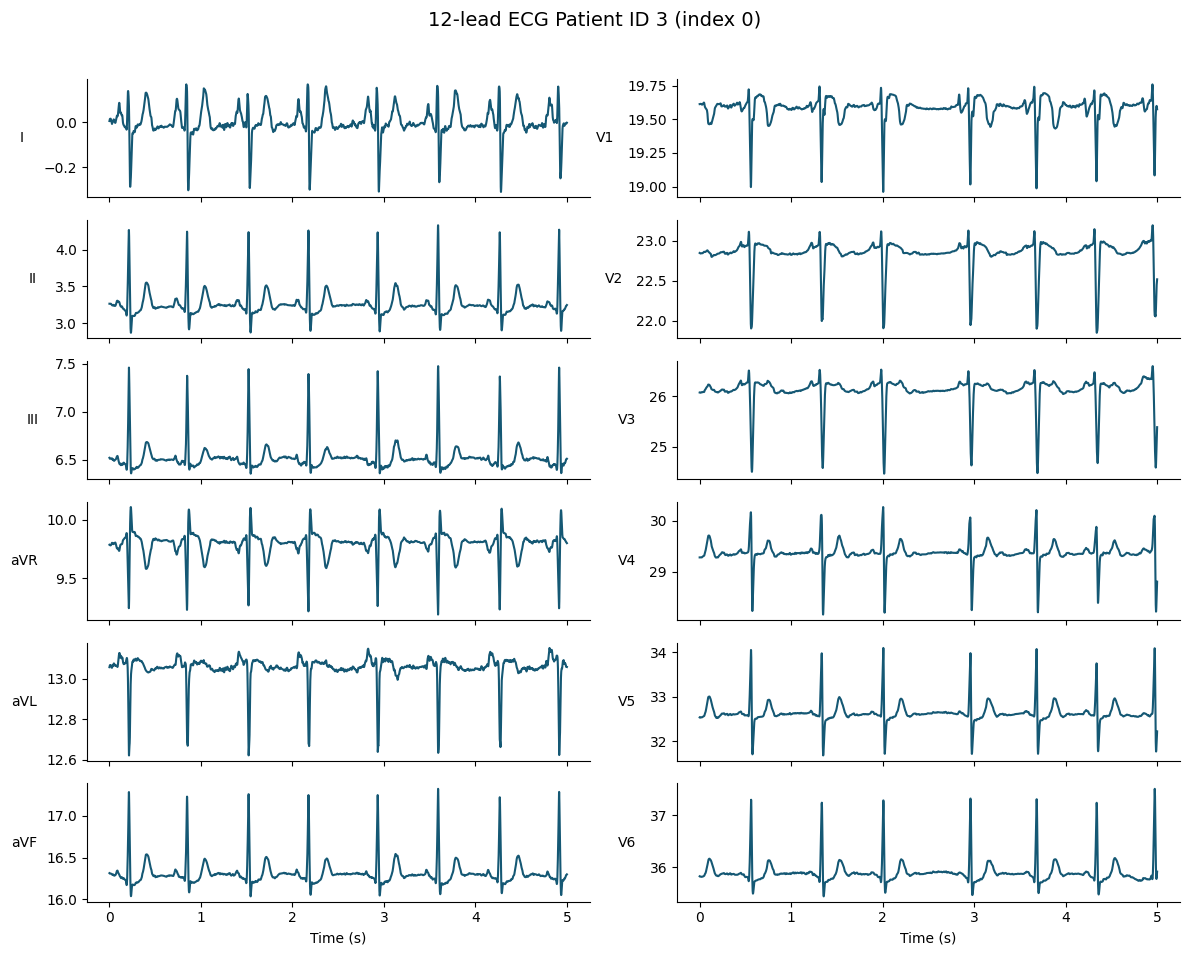

KeyboardInterrupt: 

In [16]:
def plot_12lead_for_patient(patient_id, signals, tabular_data, fs=500):
    """
    Plot 12-lead ECG for given patient_id using the already-merged `signals` array.
    Arrange leads so that limb leads (I, II, III, aVR, aVL, aVF) are in the first column
    and precordial leads (V1..V6) are in the second column.
    """
    # find index in tabular_data
    idx_list = tabular_data.index[tabular_data['ECG_patient_id'] == patient_id].tolist()
    if len(idx_list) == 0:
        raise ValueError(f"Patient id {patient_id} not found in tabular_data['ECG_patient_id'].")
    idx = int(idx_list[0])

    if idx < 0 or idx >= signals.shape[0]:
        raise IndexError(f"Found index {idx} out of range for signals (shape {signals.shape}).")

    sig = signals[idx]  # shape (n_samples, 12)
    if sig.ndim != 2 or sig.shape[1] != 12:
        raise ValueError(f"Expected signal shape (n_samples, 12), got {sig.shape}")

    n_samples = sig.shape[0]
    t = np.arange(n_samples) / fs  # seconds; change to ms if desired by multiplying by 1000

    # desired layout:
    # column 0: I, II, III, aVR, aVL, aVF
    # column 1: V1, V2, V3, V4, V5, V6
    lead_names = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']

    # mapping lead index -> (row, col) in 6x2 grid
    mapping = {
        0: (0, 0),  # I
        1: (1, 0),  # II
        2: (2, 0),  # III
        3: (3, 0),  # aVR
        4: (4, 0),  # aVL
        5: (5, 0),  # aVF
        6: (0, 1),  # V1
        7: (1, 1),  # V2
        8: (2, 1),  # V3
        9: (3, 1),  # V4
        10: (4, 1), # V5
        11: (5, 1)  # V6
    }

    # vertical offsets for visualization
    amp = np.max(np.abs(sig)) if np.max(np.abs(sig)) > 0 else 1.0
    offset = 2 * amp

    fig, axes = plt.subplots(6, 2, figsize=(12, 10), sharex=True)
    for lead_idx in range(12):
        r, c = mapping[lead_idx]
        ax = axes[r, c]
        ax.plot(t, sig[:, lead_idx] + lead_idx * offset, color='#155874')
        ax.set_ylabel(lead_names[lead_idx], rotation=0, labelpad=16, va='center')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # remove empty spines/labels for clarity
    for r in range(6):
        for c in range(2):
            axes[r, c].tick_params(axis='y', which='both', left=True)
    axes[-1, 0].set_xlabel('Time (s)')
    axes[-1, 1].set_xlabel('Time (s)')

    fig.suptitle(f'12-lead ECG Patient ID {patient_id} (index {idx})', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

# Example: plot patient with id 3
plot_12lead_for_patient(3, signals, tabular_data, fs=1000)

# Positive patient
pazienti_positivi = tabular_data[tabular_data['sport_ability'] == 1]
target_id = pazienti_positivi.iloc[0]['ECG_patient_id']
plot_12lead_for_patient(target_id, signals, tabular_data, fs=1000)

# Modello 1

In [17]:
# Architettura Semplice CNN 1D (Senza rami tabulari o GRU)
class Simple1DCNN(nn.Module):
    def __init__(self, num_leads=12):
        super(Simple1DCNN, self).__init__()

        # Blocco 1: Da 12 canali a 32
        self.conv1 = nn.Conv1d(in_channels=num_leads, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # Blocco 2: Da 32 a 64
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Blocco 3: Da 64 a 128
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Global Average Pooling: Riduce la dimensione temporale a 1
        # Indipendentemente dalla lunghezza del segnale (2500 o 5000), uscirà un vettore di dim 128
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Fully Connected finale per la classificazione
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.5) # Aiuta a prevenire l'overfitting
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Input x shape: [Batch, 12, Length]

        # Convolutional Blocks
        x = self.pool1(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool2(F.gelu(self.bn2(self.conv2(x))))
        x = self.pool3(F.gelu(self.bn3(self.conv3(x))))

        # Global Pooling
        x = self.global_pool(x) # Shape: [Batch, 128, 1]
        x = x.squeeze(-1)       # Shape: [Batch, 128]

        # Classifier
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))

        return x

In [18]:
#implementation of the ten fold cross-validation

strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_list_all_folds = []
f1_list_all_folds_train = []
sensitivity_list_all_folds = []
sensitivity_list_all_folds_train = []
specificity_list_all_folds = []
specificity_list_all_folds_train = []
accuracy_list_all_folds = []
accuracy_list_all_folds_train = []
auc_score_list_all_folds = []
auc_score_list_all_folds_train = []
fpr_list_all_folds = []
tpr_list_all_folds = []
test_loss_all_folds = []
train_loss_all_folds = []
epochs_all_fold = []
train_loss_max = []
test_loss_max = []

num_epocs = 50

for train_index, test_index in strat_kf.split(tabular_data, tabular_data['sport_ability']):
    X_train, X_test = tabular_data.iloc[train_index,:], tabular_data.iloc[test_index,:]
    ecg_train = signals[train_index,:,:]
    ecg_test = signals[test_index,:,:]

    ecg_train_segments, tabular_train_expand = segment_ecg(ecg_train, X_train)
    ecg_test_segments, tabular_test_expand = segment_ecg(ecg_test, X_test)

    Y_train = tabular_train_expand['sport_ability']
    Y_test = tabular_test_expand['sport_ability']

    X_train_final = tabular_train_expand.drop(columns=['sport_ability', 'ECG_patient_id'])
    X_test_final = tabular_test_expand.drop(columns=['sport_ability', 'ECG_patient_id'])

    X_train_final['age_at_exam'] = X_train_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_train_final['trainning_load'] = X_train_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    imputer = IterativeImputer()
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_final), columns=X_train_final.columns)

    categorical_cols = ['sex', 'sport_classification']
    numeric_cols = ['age_at_exam', 'height', 'weight', 'trainning_load']

    X_test_final['age_at_exam'] = X_test_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_test_final['trainning_load'] = X_test_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    X_test_imputed = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)

    scaler = StandardScaler()
    X_train_imputed[numeric_cols] = scaler.fit_transform(X_train_imputed[numeric_cols])
    X_test_imputed[numeric_cols] = scaler.transform(X_test_imputed[numeric_cols])

    for col in categorical_cols:
        X_train_imputed[col] = X_train_imputed[col].apply(lambda x: -1 if x == 0 else x)
        X_test_imputed[col] = X_test_imputed[col].apply(lambda x: -1 if x == 0 else x)

    train_final_df = pd.concat([X_train_imputed[numeric_cols], X_train_imputed[categorical_cols]], axis=1)
    test_final_df = pd.concat([X_test_imputed[numeric_cols], X_test_imputed[categorical_cols]], axis=1)

    train_dataset = ECGDataset(ecg_train_segments, Y_train)
    test_dataset = ECGDataset(ecg_test_segments, Y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = Simple1DCNN(num_leads=12).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    ## Variabili early-stopping
    best_test_loss = float('inf')
    patience = 5
    trigger_times = 0

    f1_list_single_fold = []
    f1_list_single_fold_train = []
    sensitivity_list_single_fold = []
    sensitivity_list_single_fold_train = []
    specificity_list_single_fold = []
    specificity_list_single_fold_train = []
    accuracy_list_single_fold = []
    accuracy_list_single_fold_train = []
    auc_score_list_single_fold = []
    auc_score_list_single_fold_train = []
    fpr_list_single_fold = []
    tpr_list_single_fold = []
    train_loss_single_fold = []
    test_loss_single_fold = []
    epochs_single_fold = []

    for epoch in tqdm(range(num_epocs)):

        train_loss = 0
        correct = 0

        all_labels = []
        all_preds = []
        all_outputs = []

        for signals_ecg, labels in train_loader:
            model.train()
            # Rimosso tabular.to(device)
            signals_ecg, labels = signals_ecg.to(device), labels.to(device)

            optimizer.zero_grad()

            # Passiamo solo il segnale al modello
            outputs = model(signals_ecg)

            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = (outputs > 0.6).int()
            labels = labels.int()
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu())
            all_preds.extend(predicted.cpu())
            all_outputs.extend(outputs.cpu())

        print('\n')
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")

        train_loss_single_fold.append(train_loss/len(train_loader))
        train_accuracy = accuracy_score(all_labels, all_preds) * 100
        f1 = f1_score(all_labels, all_preds)
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        auc_score = roc_auc_score(all_labels, all_preds)

        f1_list_single_fold_train.append(f1)
        sensitivity_list_single_fold_train.append(sensitivity)
        specificity_list_single_fold_train.append(specificity)
        accuracy_list_single_fold_train.append(train_accuracy)
        auc_score_list_single_fold_train.append(auc_score)

        model.eval()

        all_labels = []
        all_preds = []
        all_outputs = []

        with torch.no_grad():

            correct = 0
            test_loss = 0

            for signals_ecg, labels in test_loader:
                # Rimosso tabular.to(device)
                signals_ecg, labels = signals_ecg.to(device), labels.to(device)

                # Passiamo solo il segnale
                outputs = model(signals_ecg)

                loss = criterion(outputs.squeeze(), labels.squeeze())
                test_loss += loss.item()
                predicted = (outputs.squeeze() > 0.6).int()
                labels = labels.squeeze().int()
                correct += (predicted.squeeze() == labels).sum().item()
                all_labels.extend(labels.cpu())
                all_preds.extend(predicted.cpu())
                all_outputs.extend(outputs.squeeze().cpu())

            test_loss /= len(test_loader)

            test_loss_single_fold.append(test_loss)
            test_accuracy = accuracy_score(all_labels, all_preds) * 100
            f1 = f1_score(all_labels, all_preds, pos_label = 0)
            tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            auc_score = roc_auc_score(all_labels, all_preds)

            f1_list_single_fold.append(f1)
            sensitivity_list_single_fold.append(sensitivity)
            specificity_list_single_fold.append(specificity)
            accuracy_list_single_fold.append(test_accuracy)
            auc_score_list_single_fold.append(auc_score)
            fpr, tpr, _ = roc_curve(all_labels, all_outputs)
            fpr_list_single_fold.append(fpr)
            tpr_list_single_fold.append(tpr)
            epochs_single_fold.append(epoch)

            print(f"Test loss: {test_loss}, Accuracy: {test_accuracy:.2f}%", f"F1 Score: {f1:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, AUC: {auc_score:.4f}")
            print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

            ## early stopping
            if test_loss < best_test_loss:
                 best_test_loss = test_loss
                 trigger_times = 0
                 # Salviamo i pesi del modello attuale perché è il migliore finora
                 torch.save(model.state_dict(), 'best_model_fold.pth')
            else:
                 trigger_times += 1
                 # print(f"Patience: {trigger_times}/{patience}") # Decommenta se vuoi vedere il contatore

                 if trigger_times >= patience:
                     print(f"Early stopping attivato all'epoca {epoch+1}!")
                     # IMPORTANTE: Prima di uscire, ricarichiamo i pesi migliori salvati
                     # Altrimenti il modello rimarrebbe quello "peggiorato" dell'ultima epoca
                     model.load_state_dict(torch.load('best_model_fold.pth'))
                     break # Esce dal ciclo "for epoch" e passa al prossimo Fold

    max_f1 = max(f1_list_single_fold)
    max_f1_index = f1_list_single_fold.index(max_f1)

    f1_list_all_folds.append(f1_list_single_fold[max_f1_index])
    f1_list_all_folds_train.append(f1_list_single_fold_train[max_f1_index])
    sensitivity_list_all_folds.append(sensitivity_list_single_fold[max_f1_index])
    sensitivity_list_all_folds_train.append(sensitivity_list_single_fold_train[max_f1_index])
    specificity_list_all_folds.append(specificity_list_single_fold[max_f1_index])
    specificity_list_all_folds_train.append(specificity_list_single_fold_train[max_f1_index])
    accuracy_list_all_folds.append(accuracy_list_single_fold[max_f1_index])
    accuracy_list_all_folds_train.append(accuracy_list_single_fold_train[max_f1_index])
    auc_score_list_all_folds.append(auc_score_list_single_fold[max_f1_index])
    auc_score_list_all_folds_train.append(auc_score_list_single_fold_train[max_f1_index])
    fpr_list_all_folds.append(fpr_list_single_fold[max_f1_index])
    tpr_list_all_folds.append(tpr_list_single_fold[max_f1_index])
    test_loss_all_folds.append(test_loss_single_fold)
    test_loss_max.append(test_loss_single_fold[max_f1_index])
    train_loss_all_folds.append(train_loss_single_fold)
    train_loss_max.append(train_loss_single_fold[max_f1_index])
    epochs_all_fold.append(epochs_single_fold[max_f1_index])

  0%|          | 0/50 [00:00<?, ?it/s]



Epoch 1, Train Loss: 0.6588217914104462
Test loss: 0.6769442856311798, Accuracy: 32.08% F1 Score: 0.4857, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 34, FN: 72


  2%|▏         | 1/50 [00:01<01:01,  1.26s/it]



Epoch 2, Train Loss: 0.6129143365791866


  4%|▍         | 2/50 [00:01<00:43,  1.09it/s]

Test loss: 0.6335703581571579, Accuracy: 71.70% F1 Score: 0.2105, Sensitivity: 1.0000, Specificity: 0.1176, AUC: 0.5588
TP: 72, FP: 30, TN: 4, FN: 0


Epoch 3, Train Loss: 0.624358309166772


  6%|▌         | 3/50 [00:02<00:45,  1.03it/s]

Test loss: 0.6114076375961304, Accuracy: 71.70% F1 Score: 0.2105, Sensitivity: 1.0000, Specificity: 0.1176, AUC: 0.5588
TP: 72, FP: 30, TN: 4, FN: 0


Epoch 4, Train Loss: 0.57713782787323


  8%|▊         | 4/50 [00:03<00:36,  1.26it/s]

Test loss: 0.6031431555747986, Accuracy: 71.70% F1 Score: 0.2857, Sensitivity: 0.9722, Specificity: 0.1765, AUC: 0.5743
TP: 70, FP: 28, TN: 6, FN: 2


Epoch 5, Train Loss: 0.5525135504347938


 10%|█         | 5/50 [00:04<00:31,  1.42it/s]

Test loss: 0.6027399599552155, Accuracy: 58.49% F1 Score: 0.5600, Sensitivity: 0.4722, Specificity: 0.8235, AUC: 0.6479
TP: 34, FP: 6, TN: 28, FN: 38


Epoch 6, Train Loss: 0.5431442835501262


 12%|█▏        | 6/50 [00:04<00:29,  1.50it/s]

Test loss: 0.6044477298855782, Accuracy: 68.87% F1 Score: 0.4590, Sensitivity: 0.8194, Specificity: 0.4118, AUC: 0.6156
TP: 59, FP: 20, TN: 14, FN: 13


Epoch 7, Train Loss: 0.53276327252388


 14%|█▍        | 7/50 [00:05<00:27,  1.55it/s]

Test loss: 0.5855840593576431, Accuracy: 65.09% F1 Score: 0.5843, Sensitivity: 0.5972, Specificity: 0.7647, AUC: 0.6810
TP: 43, FP: 8, TN: 26, FN: 29


Epoch 8, Train Loss: 0.5277447253465652


 16%|█▌        | 8/50 [00:05<00:25,  1.65it/s]

Test loss: 0.6004269421100616, Accuracy: 67.92% F1 Score: 0.5143, Sensitivity: 0.7500, Specificity: 0.5294, AUC: 0.6397
TP: 54, FP: 16, TN: 18, FN: 18


Epoch 9, Train Loss: 0.5262895716088158


 18%|█▊        | 9/50 [00:06<00:21,  1.87it/s]

Test loss: 0.5765956938266754, Accuracy: 70.75% F1 Score: 0.4364, Sensitivity: 0.8750, Specificity: 0.3529, AUC: 0.6140
TP: 63, FP: 22, TN: 12, FN: 9


 20%|██        | 10/50 [00:06<00:20,  1.98it/s]



Epoch 10, Train Loss: 0.5359154641628265
Test loss: 0.5830596089363098, Accuracy: 70.75% F1 Score: 0.5507, Sensitivity: 0.7778, Specificity: 0.5588, AUC: 0.6683
TP: 56, FP: 15, TN: 19, FN: 16


 22%|██▏       | 11/50 [00:06<00:18,  2.14it/s]



Epoch 11, Train Loss: 0.5175762453249523
Test loss: 0.5642048865556717, Accuracy: 70.75% F1 Score: 0.5373, Sensitivity: 0.7917, Specificity: 0.5294, AUC: 0.6605
TP: 57, FP: 16, TN: 18, FN: 15


 24%|██▍       | 12/50 [00:07<00:16,  2.30it/s]



Epoch 12, Train Loss: 0.4741104819944927
Test loss: 0.6010449156165123, Accuracy: 66.04% F1 Score: 0.5814, Sensitivity: 0.6250, Specificity: 0.7353, AUC: 0.6801
TP: 45, FP: 9, TN: 25, FN: 27


 26%|██▌       | 13/50 [00:07<00:14,  2.50it/s]



Epoch 13, Train Loss: 0.4741899200848171
Test loss: 0.5939323008060455, Accuracy: 66.04% F1 Score: 0.5263, Sensitivity: 0.6944, Specificity: 0.5882, AUC: 0.6413
TP: 50, FP: 14, TN: 20, FN: 22


Epoch 14, Train Loss: 0.542256480881146


 28%|██▊       | 14/50 [00:08<00:14,  2.47it/s]

Test loss: 0.6412343308329582, Accuracy: 58.49% F1 Score: 0.5686, Sensitivity: 0.4583, Specificity: 0.8529, AUC: 0.6556
TP: 33, FP: 5, TN: 29, FN: 39


 30%|███       | 15/50 [00:08<00:13,  2.59it/s]



Epoch 15, Train Loss: 0.4674813896417618
Test loss: 0.6124085411429405, Accuracy: 71.70% F1 Score: 0.5312, Sensitivity: 0.8194, Specificity: 0.5000, AUC: 0.6597
TP: 59, FP: 17, TN: 17, FN: 13


 30%|███       | 15/50 [00:08<00:20,  1.72it/s]



Epoch 16, Train Loss: 0.466477883713586
Test loss: 0.5711989998817444, Accuracy: 65.09% F1 Score: 0.5647, Sensitivity: 0.6250, Specificity: 0.7059, AUC: 0.6654
TP: 45, FP: 10, TN: 24, FN: 27
Early stopping attivato all'epoca 16!



  2%|▏         | 1/50 [00:00<00:17,  2.78it/s]



Epoch 1, Train Loss: 0.632571646145412
Test loss: 0.6372694075107574, Accuracy: 31.43% F1 Score: 0.4783, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 33, FN: 72


  4%|▍         | 2/50 [00:00<00:15,  3.10it/s]



Epoch 2, Train Loss: 0.6005165598222187
Test loss: 0.5818527713418007, Accuracy: 69.52% F1 Score: 0.0588, Sensitivity: 1.0000, Specificity: 0.0303, AUC: 0.5152
TP: 72, FP: 32, TN: 1, FN: 0


  6%|▌         | 3/50 [00:00<00:15,  3.09it/s]



Epoch 3, Train Loss: 0.5751076191663742
Test loss: 0.5475350618362427, Accuracy: 70.48% F1 Score: 0.3111, Sensitivity: 0.9306, Specificity: 0.2121, AUC: 0.5713
TP: 67, FP: 26, TN: 7, FN: 5


Epoch 4, Train Loss: 0.5556342346327645


  8%|▊         | 4/50 [00:01<00:20,  2.24it/s]

Test loss: 0.5246367640793324, Accuracy: 71.43% F1 Score: 0.2105, Sensitivity: 0.9861, Specificity: 0.1212, AUC: 0.5537
TP: 71, FP: 29, TN: 4, FN: 1


Epoch 5, Train Loss: 0.5415461382695607


 10%|█         | 5/50 [00:02<00:23,  1.88it/s]

Test loss: 0.49932725355029106, Accuracy: 71.43% F1 Score: 0.4444, Sensitivity: 0.8750, Specificity: 0.3636, AUC: 0.6193
TP: 63, FP: 21, TN: 12, FN: 9


Epoch 6, Train Loss: 0.5371073399271283


 12%|█▏        | 6/50 [00:02<00:21,  2.02it/s]

Test loss: 0.5014540888369083, Accuracy: 71.43% F1 Score: 0.3182, Sensitivity: 0.9444, Specificity: 0.2121, AUC: 0.5783
TP: 68, FP: 26, TN: 7, FN: 4


Epoch 7, Train Loss: 0.5188138889414924


 14%|█▍        | 7/50 [00:03<00:19,  2.19it/s]

Test loss: 0.5564488917589188, Accuracy: 61.90% F1 Score: 0.5833, Sensitivity: 0.5139, Specificity: 0.8485, AUC: 0.6812
TP: 37, FP: 5, TN: 28, FN: 35


Epoch 8, Train Loss: 0.5155326681477683


 16%|█▌        | 8/50 [00:03<00:17,  2.42it/s]

Test loss: 0.6078088264912367, Accuracy: 70.48% F1 Score: 0.1143, Sensitivity: 1.0000, Specificity: 0.0606, AUC: 0.5303
TP: 72, FP: 31, TN: 2, FN: 0


Epoch 9, Train Loss: 0.4959469203438078


 18%|█▊        | 9/50 [00:03<00:15,  2.62it/s]

Test loss: 0.5604312345385551, Accuracy: 59.05% F1 Score: 0.5057, Sensitivity: 0.5556, Specificity: 0.6667, AUC: 0.6111
TP: 40, FP: 11, TN: 22, FN: 32


Epoch 10, Train Loss: 0.5028143588985715


 20%|██        | 10/50 [00:04<00:14,  2.74it/s]

Test loss: 0.47487108036875725, Accuracy: 76.19% F1 Score: 0.5763, Sensitivity: 0.8750, Specificity: 0.5152, AUC: 0.6951
TP: 63, FP: 16, TN: 17, FN: 9


Epoch 11, Train Loss: 0.50294577223914


 22%|██▏       | 11/50 [00:04<00:13,  2.91it/s]

Test loss: 0.5061825104057789, Accuracy: 71.43% F1 Score: 0.4828, Sensitivity: 0.8472, Specificity: 0.4242, AUC: 0.6357
TP: 61, FP: 19, TN: 14, FN: 11


Epoch 12, Train Loss: 0.49818916405950275


 24%|██▍       | 12/50 [00:04<00:12,  2.98it/s]

Test loss: 0.6294515132904053, Accuracy: 54.29% F1 Score: 0.5472, Sensitivity: 0.3889, Specificity: 0.8788, AUC: 0.6338
TP: 28, FP: 4, TN: 29, FN: 44


Epoch 13, Train Loss: 0.4746867631162916


 26%|██▌       | 13/50 [00:04<00:12,  3.08it/s]

Test loss: 0.4658058434724808, Accuracy: 72.38% F1 Score: 0.5085, Sensitivity: 0.8472, Specificity: 0.4545, AUC: 0.6509
TP: 61, FP: 18, TN: 15, FN: 11


Epoch 14, Train Loss: 0.46253055121217457


 28%|██▊       | 14/50 [00:05<00:11,  3.20it/s]

Test loss: 0.5128517299890518, Accuracy: 66.67% F1 Score: 0.5455, Sensitivity: 0.6806, Specificity: 0.6364, AUC: 0.6585
TP: 49, FP: 12, TN: 21, FN: 23


Epoch 15, Train Loss: 0.49689910454409464


 30%|███       | 15/50 [00:05<00:10,  3.30it/s]

Test loss: 0.5047645196318626, Accuracy: 65.71% F1 Score: 0.5500, Sensitivity: 0.6528, Specificity: 0.6667, AUC: 0.6597
TP: 47, FP: 11, TN: 22, FN: 25


Epoch 16, Train Loss: 0.5057026020118168


 32%|███▏      | 16/50 [00:05<00:10,  3.36it/s]

Test loss: 0.5519837141036987, Accuracy: 73.33% F1 Score: 0.5625, Sensitivity: 0.8194, Specificity: 0.5455, AUC: 0.6824
TP: 59, FP: 15, TN: 18, FN: 13


Epoch 17, Train Loss: 0.47431713342666626


 34%|███▍      | 17/50 [00:06<00:09,  3.36it/s]

Test loss: 0.45868178084492683, Accuracy: 73.33% F1 Score: 0.5172, Sensitivity: 0.8611, Specificity: 0.4545, AUC: 0.6578
TP: 62, FP: 18, TN: 15, FN: 10


Epoch 18, Train Loss: 0.4597858488559723


 36%|███▌      | 18/50 [00:06<00:09,  3.25it/s]

Test loss: 0.481868639588356, Accuracy: 73.33% F1 Score: 0.5625, Sensitivity: 0.8194, Specificity: 0.5455, AUC: 0.6824
TP: 59, FP: 15, TN: 18, FN: 13


 38%|███▊      | 19/50 [00:06<00:10,  2.91it/s]



Epoch 19, Train Loss: 0.45967821563993183
Test loss: 0.5004501640796661, Accuracy: 70.48% F1 Score: 0.5974, Sensitivity: 0.7083, Specificity: 0.6970, AUC: 0.7027
TP: 51, FP: 10, TN: 23, FN: 21


 40%|████      | 20/50 [00:07<00:09,  3.13it/s]



Epoch 20, Train Loss: 0.4158260077238083
Test loss: 0.5116348713636398, Accuracy: 68.57% F1 Score: 0.5823, Sensitivity: 0.6806, Specificity: 0.6970, AUC: 0.6888
TP: 49, FP: 10, TN: 23, FN: 23


 42%|████▏     | 21/50 [00:07<00:08,  3.29it/s]



Epoch 21, Train Loss: 0.4173023849725723
Test loss: 0.5876981168985367, Accuracy: 66.67% F1 Score: 0.5977, Sensitivity: 0.6111, Specificity: 0.7879, AUC: 0.6995
TP: 44, FP: 7, TN: 26, FN: 28


 42%|████▏     | 21/50 [00:07<00:10,  2.73it/s]



Epoch 22, Train Loss: 0.4537321605852672
Test loss: 0.4621775150299072, Accuracy: 69.52% F1 Score: 0.6000, Sensitivity: 0.6806, Specificity: 0.7273, AUC: 0.7039
TP: 49, FP: 9, TN: 24, FN: 23
Early stopping attivato all'epoca 22!



  2%|▏         | 1/50 [00:00<00:13,  3.50it/s]



Epoch 1, Train Loss: 0.6734561792441777
Test loss: 0.6686490178108215, Accuracy: 31.43% F1 Score: 0.4783, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 33, FN: 72


  4%|▍         | 2/50 [00:00<00:13,  3.61it/s]



Epoch 2, Train Loss: 0.6273238233157566
Test loss: 0.5822473168373108, Accuracy: 68.57% F1 Score: 0.0000, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 72, FP: 33, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:13,  3.52it/s]



Epoch 3, Train Loss: 0.5801501167672021
Test loss: 0.5563117936253548, Accuracy: 68.57% F1 Score: 0.0000, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 72, FP: 33, TN: 0, FN: 0


  8%|▊         | 4/50 [00:01<00:13,  3.45it/s]



Epoch 4, Train Loss: 0.5920797267130443
Test loss: 0.5437755063176155, Accuracy: 67.62% F1 Score: 0.0000, Sensitivity: 0.9861, Specificity: 0.0000, AUC: 0.4931
TP: 71, FP: 33, TN: 0, FN: 1


 10%|█         | 5/50 [00:01<00:13,  3.46it/s]



Epoch 5, Train Loss: 0.5548444624458041
Test loss: 0.5136332511901855, Accuracy: 72.38% F1 Score: 0.4528, Sensitivity: 0.8889, Specificity: 0.3636, AUC: 0.6263
TP: 64, FP: 21, TN: 12, FN: 8


 12%|█▏        | 6/50 [00:01<00:12,  3.58it/s]



Epoch 6, Train Loss: 0.5638793621744428
Test loss: 0.5226976573467255, Accuracy: 72.38% F1 Score: 0.4082, Sensitivity: 0.9167, Specificity: 0.3030, AUC: 0.6098
TP: 66, FP: 23, TN: 10, FN: 6


 14%|█▍        | 7/50 [00:01<00:10,  3.94it/s]



Epoch 7, Train Loss: 0.5623045116662979
Test loss: 0.5150501430034637, Accuracy: 71.43% F1 Score: 0.5000, Sensitivity: 0.8333, Specificity: 0.4545, AUC: 0.6439
TP: 60, FP: 18, TN: 15, FN: 12


Epoch 8, Train Loss: 0.5319937978472028


 16%|█▌        | 8/50 [00:02<00:10,  4.16it/s]

Test loss: 0.5008921846747398, Accuracy: 73.33% F1 Score: 0.5333, Sensitivity: 0.8472, Specificity: 0.4848, AUC: 0.6660
TP: 61, FP: 17, TN: 16, FN: 11


Epoch 9, Train Loss: 0.5072598989520755


 18%|█▊        | 9/50 [00:02<00:09,  4.30it/s]

Test loss: 0.49422844499349594, Accuracy: 70.48% F1 Score: 0.4746, Sensitivity: 0.8333, Specificity: 0.4242, AUC: 0.6288
TP: 60, FP: 19, TN: 14, FN: 12


Epoch 10, Train Loss: 0.5037060252257756


 20%|██        | 10/50 [00:02<00:09,  4.39it/s]

Test loss: 0.48468344658613205, Accuracy: 74.29% F1 Score: 0.5091, Sensitivity: 0.8889, Specificity: 0.4242, AUC: 0.6566
TP: 64, FP: 19, TN: 14, FN: 8


Epoch 11, Train Loss: 0.5006839632987976


 22%|██▏       | 11/50 [00:02<00:08,  4.48it/s]

Test loss: 0.557006374001503, Accuracy: 63.81% F1 Score: 0.4865, Sensitivity: 0.6806, Specificity: 0.5455, AUC: 0.6130
TP: 49, FP: 15, TN: 18, FN: 23


Epoch 12, Train Loss: 0.47942954088960377


 24%|██▍       | 12/50 [00:02<00:08,  4.60it/s]

Test loss: 0.5113725662231445, Accuracy: 71.43% F1 Score: 0.5161, Sensitivity: 0.8194, Specificity: 0.4848, AUC: 0.6521
TP: 59, FP: 17, TN: 16, FN: 13


Epoch 13, Train Loss: 0.48864709053720745
Test loss: 0.5852891057729721, Accuracy: 62.86% F1 Score: 0.5412, Sensitivity: 0.5972, Specificity: 0.6970, AUC: 0.6471
TP: 43, FP: 10, TN: 23, FN: 29


 28%|██▊       | 14/50 [00:03<00:07,  4.73it/s]



Epoch 14, Train Loss: 0.48024976679256987
Test loss: 0.5171680897474289, Accuracy: 71.43% F1 Score: 0.5946, Sensitivity: 0.7361, Specificity: 0.6667, AUC: 0.7014
TP: 53, FP: 11, TN: 22, FN: 19


Epoch 15, Train Loss: 0.48529149166175295


 28%|██▊       | 14/50 [00:03<00:09,  3.90it/s]

Test loss: 0.549773596227169, Accuracy: 61.90% F1 Score: 0.5652, Sensitivity: 0.5417, Specificity: 0.7879, AUC: 0.6648
TP: 39, FP: 7, TN: 26, FN: 33
Early stopping attivato all'epoca 15!



  2%|▏         | 1/50 [00:00<00:10,  4.49it/s]



Epoch 1, Train Loss: 0.6574085993426186
Test loss: 0.642247274518013, Accuracy: 31.43% F1 Score: 0.4783, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 33, FN: 72


  4%|▍         | 2/50 [00:00<00:10,  4.43it/s]



Epoch 2, Train Loss: 0.6248567402362823
Test loss: 0.5820472314953804, Accuracy: 68.57% F1 Score: 0.0000, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 72, FP: 33, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:10,  4.53it/s]



Epoch 3, Train Loss: 0.5760930925607681
Test loss: 0.5540025681257248, Accuracy: 69.52% F1 Score: 0.0588, Sensitivity: 1.0000, Specificity: 0.0303, AUC: 0.5152
TP: 72, FP: 32, TN: 1, FN: 0


  8%|▊         | 4/50 [00:00<00:10,  4.57it/s]



Epoch 4, Train Loss: 0.5904511447463717
Test loss: 0.5480036959052086, Accuracy: 67.62% F1 Score: 0.2609, Sensitivity: 0.9028, Specificity: 0.1818, AUC: 0.5423
TP: 65, FP: 27, TN: 6, FN: 7


 10%|█         | 5/50 [00:01<00:09,  4.61it/s]



Epoch 5, Train Loss: 0.5730884905372348
Test loss: 0.5246170237660408, Accuracy: 68.57% F1 Score: 0.2326, Sensitivity: 0.9306, Specificity: 0.1515, AUC: 0.5410
TP: 67, FP: 28, TN: 5, FN: 5


 12%|█▏        | 6/50 [00:01<00:09,  4.53it/s]



Epoch 6, Train Loss: 0.5740216140236173
Test loss: 0.5206020995974541, Accuracy: 72.38% F1 Score: 0.4528, Sensitivity: 0.8889, Specificity: 0.3636, AUC: 0.6263
TP: 64, FP: 21, TN: 12, FN: 8


 14%|█▍        | 7/50 [00:01<00:09,  4.65it/s]



Epoch 7, Train Loss: 0.5684445947408676
Test loss: 0.5249946564435959, Accuracy: 72.38% F1 Score: 0.3256, Sensitivity: 0.9583, Specificity: 0.2121, AUC: 0.5852
TP: 69, FP: 26, TN: 7, FN: 3


Epoch 8, Train Loss: 0.5337215087243489


 16%|█▌        | 8/50 [00:01<00:08,  4.72it/s]

Test loss: 0.5208313316106796, Accuracy: 71.43% F1 Score: 0.5161, Sensitivity: 0.8194, Specificity: 0.4848, AUC: 0.6521
TP: 59, FP: 17, TN: 16, FN: 13


Epoch 9, Train Loss: 0.5265463611909321


 18%|█▊        | 9/50 [00:01<00:08,  4.69it/s]

Test loss: 0.4923425689339638, Accuracy: 73.33% F1 Score: 0.4815, Sensitivity: 0.8889, Specificity: 0.3939, AUC: 0.6414
TP: 64, FP: 20, TN: 13, FN: 8


Epoch 10, Train Loss: 0.5229749658278057


 20%|██        | 10/50 [00:02<00:08,  4.65it/s]

Test loss: 0.5491829365491867, Accuracy: 64.76% F1 Score: 0.5316, Sensitivity: 0.6528, Specificity: 0.6364, AUC: 0.6446
TP: 47, FP: 12, TN: 21, FN: 25


Epoch 11, Train Loss: 0.5174475695405688


 22%|██▏       | 11/50 [00:02<00:08,  4.65it/s]

Test loss: 0.49839403480291367, Accuracy: 77.14% F1 Score: 0.5200, Sensitivity: 0.9444, Specificity: 0.3939, AUC: 0.6692
TP: 68, FP: 20, TN: 13, FN: 4


Epoch 12, Train Loss: 0.5130570807627269


 24%|██▍       | 12/50 [00:02<00:08,  4.72it/s]

Test loss: 0.49802137166261673, Accuracy: 68.57% F1 Score: 0.5600, Sensitivity: 0.7083, Specificity: 0.6364, AUC: 0.6723
TP: 51, FP: 12, TN: 21, FN: 21


Epoch 13, Train Loss: 0.5228165090084076


 26%|██▌       | 13/50 [00:02<00:07,  4.67it/s]

Test loss: 0.471000000834465, Accuracy: 73.33% F1 Score: 0.5758, Sensitivity: 0.8056, Specificity: 0.5758, AUC: 0.6907
TP: 58, FP: 14, TN: 19, FN: 14


Epoch 14, Train Loss: 0.4956960358789989


 30%|███       | 15/50 [00:03<00:07,  4.83it/s]

Test loss: 0.4973905384540558, Accuracy: 67.62% F1 Score: 0.5750, Sensitivity: 0.6667, Specificity: 0.6970, AUC: 0.6818
TP: 48, FP: 10, TN: 23, FN: 24


Epoch 15, Train Loss: 0.558825399194445
Test loss: 0.5645325109362602, Accuracy: 66.67% F1 Score: 0.5977, Sensitivity: 0.6111, Specificity: 0.7879, AUC: 0.6995
TP: 44, FP: 7, TN: 26, FN: 28


 32%|███▏      | 16/50 [00:03<00:07,  4.84it/s]



Epoch 16, Train Loss: 0.4964548093932016
Test loss: 0.520246185362339, Accuracy: 77.14% F1 Score: 0.4286, Sensitivity: 1.0000, Specificity: 0.2727, AUC: 0.6364
TP: 72, FP: 24, TN: 9, FN: 0


Epoch 17, Train Loss: 0.48481856499399456


 34%|███▍      | 17/50 [00:03<00:06,  4.83it/s]

Test loss: 0.5886958539485931, Accuracy: 61.90% F1 Score: 0.5833, Sensitivity: 0.5139, Specificity: 0.8485, AUC: 0.6812
TP: 37, FP: 5, TN: 28, FN: 35


Epoch 18, Train Loss: 0.4831667457308088
Test loss: 0.46876784414052963, Accuracy: 77.14% F1 Score: 0.5200, Sensitivity: 0.9444, Specificity: 0.3939, AUC: 0.6692
TP: 68, FP: 20, TN: 13, FN: 4


 38%|███▊      | 19/50 [00:04<00:06,  4.76it/s]



Epoch 19, Train Loss: 0.4769462155444281
Test loss: 0.45315950363874435, Accuracy: 72.38% F1 Score: 0.5915, Sensitivity: 0.7639, Specificity: 0.6364, AUC: 0.7001
TP: 55, FP: 12, TN: 21, FN: 17


 40%|████      | 20/50 [00:04<00:06,  4.80it/s]



Epoch 20, Train Loss: 0.4635639957019261
Test loss: 0.461333803832531, Accuracy: 79.05% F1 Score: 0.5769, Sensitivity: 0.9444, Specificity: 0.4545, AUC: 0.6995
TP: 68, FP: 18, TN: 15, FN: 4


 42%|████▏     | 21/50 [00:04<00:06,  4.80it/s]



Epoch 21, Train Loss: 0.44689137382166727
Test loss: 0.5807273238897324, Accuracy: 63.81% F1 Score: 0.5476, Sensitivity: 0.6111, Specificity: 0.6970, AUC: 0.6540
TP: 44, FP: 10, TN: 23, FN: 28


 44%|████▍     | 22/50 [00:04<00:05,  4.78it/s]



Epoch 22, Train Loss: 0.48799201207501547
Test loss: 0.5558773651719093, Accuracy: 73.33% F1 Score: 0.3913, Sensitivity: 0.9444, Specificity: 0.2727, AUC: 0.6086
TP: 68, FP: 24, TN: 9, FN: 4


 46%|████▌     | 23/50 [00:04<00:05,  4.84it/s]



Epoch 23, Train Loss: 0.4639290528638022
Test loss: 0.5827034264802933, Accuracy: 57.14% F1 Score: 0.5361, Sensitivity: 0.4722, Specificity: 0.7879, AUC: 0.6301
TP: 34, FP: 7, TN: 26, FN: 38


Epoch 24, Train Loss: 0.4603210304464613


 48%|████▊     | 24/50 [00:05<00:05,  4.76it/s]

Test loss: 0.44502028077840805, Accuracy: 75.24% F1 Score: 0.5806, Sensitivity: 0.8472, Specificity: 0.5455, AUC: 0.6963
TP: 61, FP: 15, TN: 18, FN: 11


Epoch 25, Train Loss: 0.45202062811170307


 50%|█████     | 25/50 [00:05<00:05,  4.77it/s]

Test loss: 0.4651075750589371, Accuracy: 71.43% F1 Score: 0.5455, Sensitivity: 0.7917, Specificity: 0.5455, AUC: 0.6686
TP: 57, FP: 15, TN: 18, FN: 15


Epoch 26, Train Loss: 0.4254807893718992


 52%|█████▏    | 26/50 [00:05<00:05,  4.76it/s]

Test loss: 0.5089341178536415, Accuracy: 70.48% F1 Score: 0.5231, Sensitivity: 0.7917, Specificity: 0.5152, AUC: 0.6534
TP: 57, FP: 16, TN: 17, FN: 15


Epoch 27, Train Loss: 0.4266136884689331


 54%|█████▍    | 27/50 [00:05<00:04,  4.81it/s]

Test loss: 0.5242988243699074, Accuracy: 74.29% F1 Score: 0.5970, Sensitivity: 0.8056, Specificity: 0.6061, AUC: 0.7058
TP: 58, FP: 13, TN: 20, FN: 14


Epoch 28, Train Loss: 0.43675462901592255


 56%|█████▌    | 28/50 [00:05<00:04,  4.83it/s]

Test loss: 0.5022410936653614, Accuracy: 78.10% F1 Score: 0.4889, Sensitivity: 0.9861, Specificity: 0.3333, AUC: 0.6597
TP: 71, FP: 22, TN: 11, FN: 1


Epoch 29, Train Loss: 0.4262505897453853
Test loss: 0.4714238867163658, Accuracy: 77.14% F1 Score: 0.6000, Sensitivity: 0.8750, Specificity: 0.5455, AUC: 0.7102
TP: 63, FP: 15, TN: 18, FN: 9
Early stopping attivato all'epoca 29!


  2%|▏         | 1/50 [00:00<00:10,  4.78it/s]



Epoch 1, Train Loss: 0.6341630284275327
Test loss: 0.6148505806922913, Accuracy: 56.19% F1 Score: 0.1481, Sensitivity: 0.7639, Specificity: 0.1212, AUC: 0.4426
TP: 55, FP: 29, TN: 4, FN: 17


  4%|▍         | 2/50 [00:00<00:10,  4.69it/s]



Epoch 2, Train Loss: 0.6043524060930524
Test loss: 0.5769698843359947, Accuracy: 68.57% F1 Score: 0.0000, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 72, FP: 33, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:10,  4.65it/s]



Epoch 3, Train Loss: 0.5796572353158679
Test loss: 0.5703228190541267, Accuracy: 68.57% F1 Score: 0.0000, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 72, FP: 33, TN: 0, FN: 0


  8%|▊         | 4/50 [00:00<00:09,  4.77it/s]



Epoch 4, Train Loss: 0.5592603491885322
Test loss: 0.5804105699062347, Accuracy: 64.76% F1 Score: 0.4478, Sensitivity: 0.7361, Specificity: 0.4545, AUC: 0.5953
TP: 53, FP: 18, TN: 15, FN: 19


 10%|█         | 5/50 [00:01<00:09,  4.78it/s]



Epoch 5, Train Loss: 0.5437592033829007
Test loss: 0.6122757270932198, Accuracy: 58.10% F1 Score: 0.2414, Sensitivity: 0.7500, Specificity: 0.2121, AUC: 0.4811
TP: 54, FP: 26, TN: 7, FN: 18


 12%|█▏        | 6/50 [00:01<00:10,  4.35it/s]



Epoch 6, Train Loss: 0.5137225219181606
Test loss: 0.5794001445174217, Accuracy: 66.67% F1 Score: 0.2222, Sensitivity: 0.9028, Specificity: 0.1515, AUC: 0.5271
TP: 65, FP: 28, TN: 5, FN: 7


 14%|█▍        | 7/50 [00:01<00:10,  4.15it/s]



Epoch 7, Train Loss: 0.5150283234460014
Test loss: 0.5857076719403267, Accuracy: 69.52% F1 Score: 0.4667, Sensitivity: 0.8194, Specificity: 0.4242, AUC: 0.6218
TP: 59, FP: 19, TN: 14, FN: 13


 16%|█▌        | 8/50 [00:01<00:10,  3.94it/s]



Epoch 8, Train Loss: 0.5021961480379105
Test loss: 0.5440781787037849, Accuracy: 68.57% F1 Score: 0.4000, Sensitivity: 0.8472, Specificity: 0.3333, AUC: 0.5903
TP: 61, FP: 22, TN: 11, FN: 11


 18%|█▊        | 9/50 [00:02<00:10,  3.76it/s]



Epoch 9, Train Loss: 0.4772595113941601
Test loss: 0.658767394721508, Accuracy: 57.14% F1 Score: 0.3478, Sensitivity: 0.6667, Specificity: 0.3636, AUC: 0.5152
TP: 48, FP: 21, TN: 12, FN: 24


 20%|██        | 10/50 [00:02<00:10,  3.78it/s]



Epoch 10, Train Loss: 0.478289287005152
Test loss: 0.5851743742823601, Accuracy: 67.62% F1 Score: 0.3462, Sensitivity: 0.8611, Specificity: 0.2727, AUC: 0.5669
TP: 62, FP: 24, TN: 9, FN: 10


 22%|██▏       | 11/50 [00:02<00:10,  3.78it/s]



Epoch 11, Train Loss: 0.46231519324438913
Test loss: 0.6384981125593185, Accuracy: 63.81% F1 Score: 0.3667, Sensitivity: 0.7778, Specificity: 0.3333, AUC: 0.5556
TP: 56, FP: 22, TN: 11, FN: 16


 24%|██▍       | 12/50 [00:02<00:10,  3.77it/s]



Epoch 12, Train Loss: 0.4420434044940131
Test loss: 0.5631333813071251, Accuracy: 66.67% F1 Score: 0.3860, Sensitivity: 0.8194, Specificity: 0.3333, AUC: 0.5764
TP: 59, FP: 22, TN: 11, FN: 13


 24%|██▍       | 12/50 [00:03<00:10,  3.70it/s]



Epoch 13, Train Loss: 0.42462818537439617
Test loss: 0.6736327335238457, Accuracy: 60.95% F1 Score: 0.3881, Sensitivity: 0.7083, Specificity: 0.3939, AUC: 0.5511
TP: 51, FP: 20, TN: 13, FN: 21
Early stopping attivato all'epoca 13!


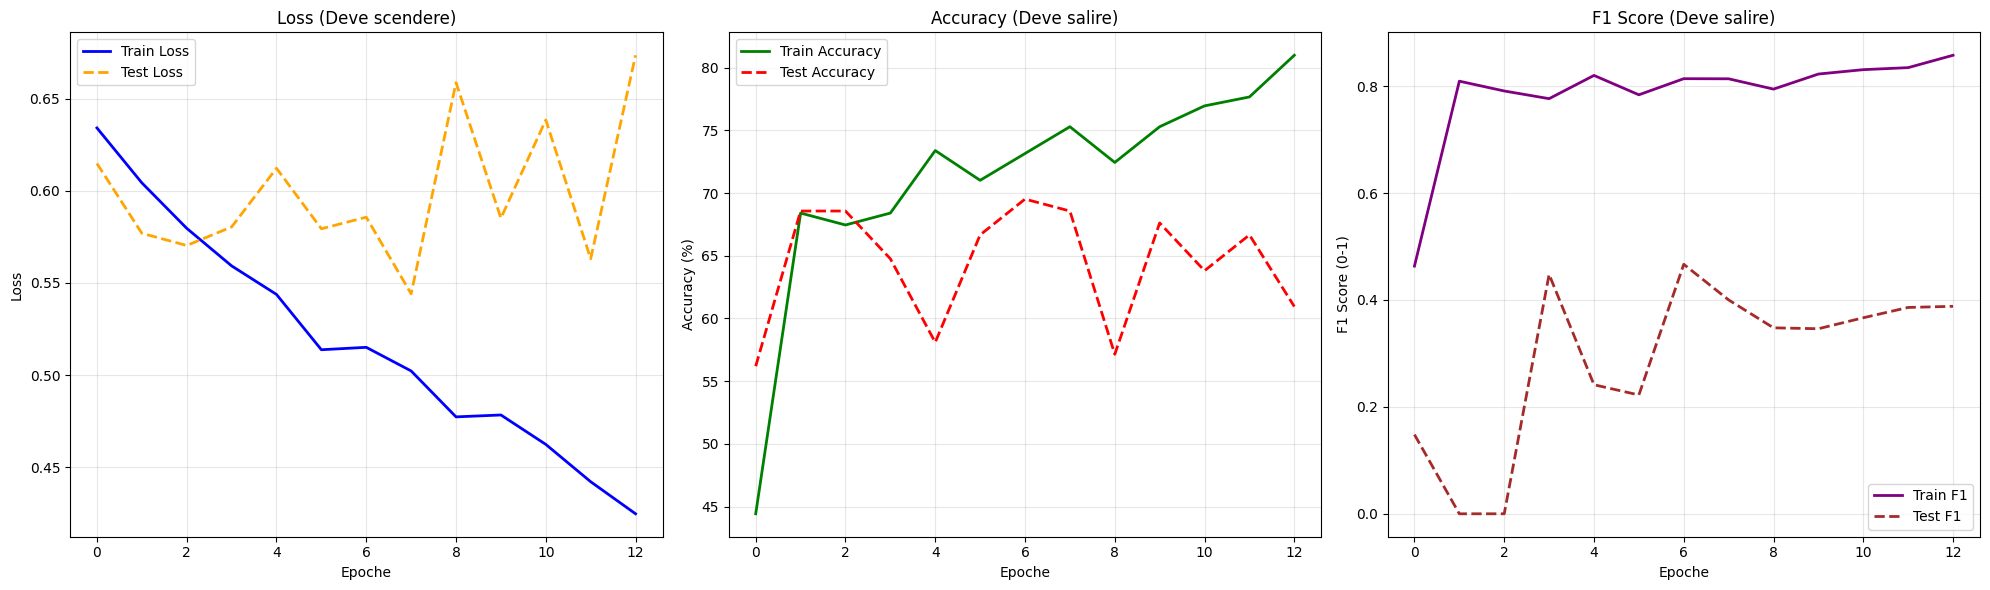

In [19]:
import matplotlib.pyplot as plt

# Grafici dell'ULTIMO FOLD
# Creiamo una figura con 3 grafici affiancati (1 riga, 3 colonne)
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# --- Grafico 1: LOSS (Errore) ---
# Questo ci dice se il modello sta imparando (deve scendere)
axs[0].plot(train_loss_single_fold, label='Train Loss', color='blue', linewidth=2)
axs[0].plot(test_loss_single_fold, label='Test Loss', color='orange', linestyle='--', linewidth=2)
axs[0].set_title('Loss (Deve scendere)')
axs[0].set_xlabel('Epoche')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# --- Grafico 2: ACCURACY ---
# Ci dice la percentuale totale di risposte corrette (deve salire)
axs[1].plot(accuracy_list_single_fold_train, label='Train Accuracy', color='green', linewidth=2)
axs[1].plot(accuracy_list_single_fold, label='Test Accuracy', color='red', linestyle='--', linewidth=2)
axs[1].set_title('Accuracy (Deve salire)')
axs[1].set_xlabel('Epoche')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# --- Grafico 3: F1 SCORE ---
# Critico per dati sbilanciati o medici: media armonica tra precisione e recupero
axs[2].plot(f1_list_single_fold_train, label='Train F1', color='purple', linewidth=2)
axs[2].plot(f1_list_single_fold, label='Test F1', color='brown', linestyle='--', linewidth=2)
axs[2].set_title('F1 Score (Deve salire)')
axs[2].set_xlabel('Epoche')
axs[2].set_ylabel('F1 Score (0-1)')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

plt.tight_layout() # Aggiusta automaticamente gli spazi tra i grafici
plt.show()

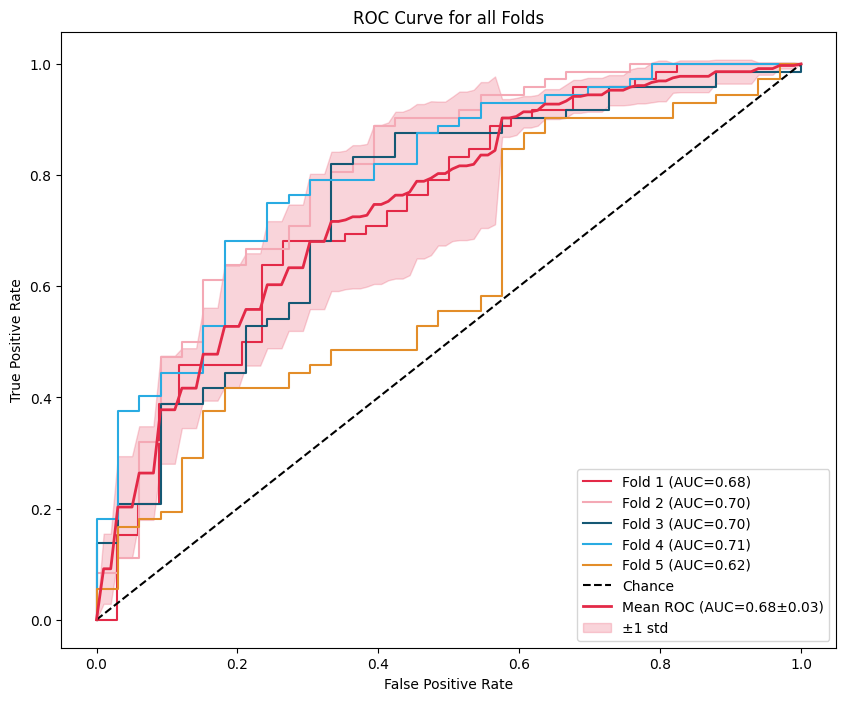

In [20]:
plt.figure(figsize=(10, 8))

# Custom color palette
colors = [
    "#E32947",  # red
    "#F4A9B5",  # pink
    "#155874",  # dark blue
    "#29ABE2",  # light blue
    "#E38D29",  # orange
    "#E3DA29",  # yellow
    "#7FE329",  # green (flashy)
    "#BFBFBF",  # grey
    "#00B050",  # green (basic)
    "#7030A0",  # purple
    "#996633",  # brown
]
# Repeat colors if more folds than colors
while len(colors) < len(fpr_list_all_folds):
    colors += colors

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for i in range(len(fpr_list_all_folds)):
    interp_tpr = np.interp(mean_fpr, fpr_list_all_folds[i], tpr_list_all_folds[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    auc_val = auc_score_list_all_folds[i] if i < len(auc_score_list_all_folds) else None
    aucs.append(auc_val)
    plt.plot(
        fpr_list_all_folds[i],
        tpr_list_all_folds[i],
        color=colors[i],
        label=f'Fold {i+1} (AUC={auc_val:.2f})'
    )

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')

# Mean and std curves
tprs = np.array(tprs)
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="#E32947",
    label=f'Mean ROC (AUC={mean_auc:.2f}±{std_auc:.2f})',
    linewidth=2
)
plt.fill_between(
    mean_fpr,
    mean_tpr - std_tpr,
    mean_tpr + std_tpr,
    color="#E32947",
    alpha=0.2,
    label='±1 std'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all Folds')
plt.legend(loc='lower right')
plt.show()

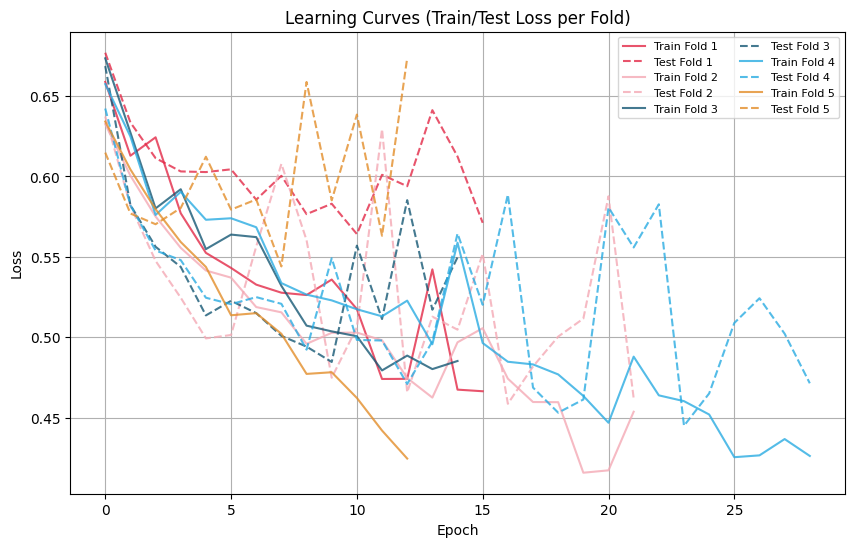

In [21]:
# Plot learning curves (train and test loss per epoch for each fold)
plt.figure(figsize=(10, 6))

for i in range(len(train_loss_all_folds)):
    plt.plot(train_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, label=f'Train Fold {i+1}')
    plt.plot(test_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, linestyle='--', label=f'Test Fold {i+1}')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves (Train/Test Loss per Fold)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()

=== REPORT PERFORMANCE MEDIE (10-Fold CV) ===
      Accuracy  F1 Score  Sensitivity (Recall)  Specificity     AUC
mean    0.7054    0.5691                0.7417       0.6257  0.6837
std     0.0436    0.0576                0.1101       0.1399  0.0363
min     0.6509    0.4667                0.5972       0.4242  0.6218
max     0.7714    0.6000                0.8750       0.7647  0.7102


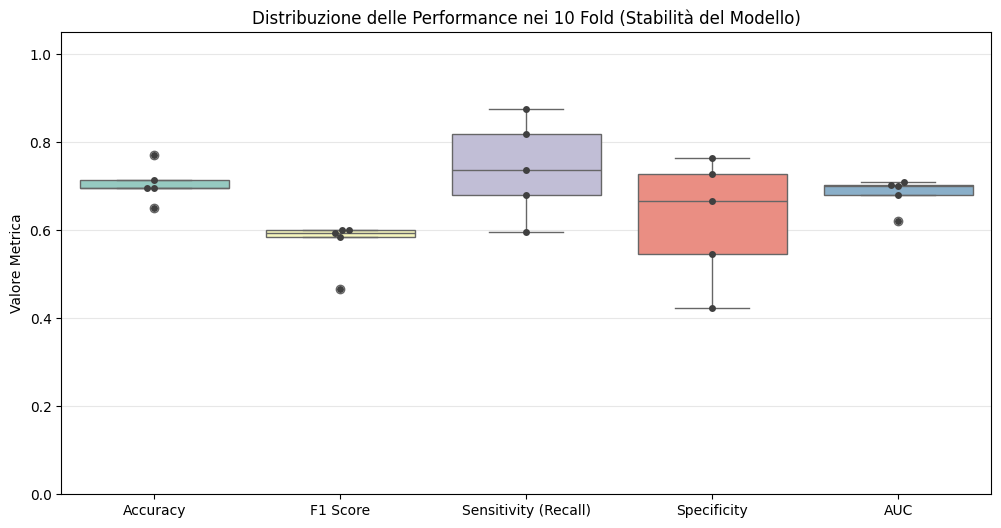

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Creazione di un DataFrame con tutti i risultati
results_data = {
    'Accuracy': np.array(accuracy_list_all_folds) / 100,  # <--- DIVISO PER 100
    'F1 Score': f1_list_all_folds,
    'Sensitivity (Recall)': sensitivity_list_all_folds,
    'Specificity': specificity_list_all_folds,
    'AUC': auc_score_list_all_folds
}

df_results = pd.DataFrame(results_data)

# 2. Calcolo delle Statistiche (Media e Deviazione Standard)
# La deviazione standard (std) ti dice quanto il modello è "instabile" tra un fold e l'altro
summary = df_results.describe().loc[['mean', 'std', 'min', 'max']]

print("=== REPORT PERFORMANCE MEDIE (10-Fold CV) ===")
print(summary.round(4))

# 3. Visualizzazione Grafica (Boxplot)
# Questo grafico è fondamentale: la linea verde è la mediana, la scatola è dove cade il 50% dei casi.
# Se la scatola è molto "alta", il modello è instabile. Se è schiacciata, è molto robusto.
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, palette="Set3")
sns.swarmplot(data=df_results, color=".25") # Aggiunge i punti reali per vedere la dispersione

plt.title('Distribuzione delle Performance nei 10 Fold (Stabilità del Modello)')
plt.ylabel('Valore Metrica')
plt.grid(True, axis='y', alpha=0.3)
plt.ylim(0, 1.05) # Fissa l'asse Y tra 0 e 1 (o poco più per l'accuracy se è in %)
# Se l'accuracy è in scala 0-100, commenta la riga sopra o adattala a (0, 105)

plt.show();

<Figure size 800x600 with 0 Axes>

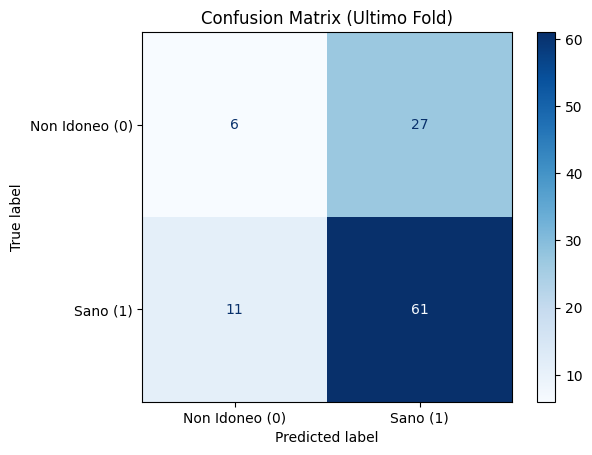

DETTAGLIO NUMERICO (Ultimo Test Set)
Veri Non Idonei (TN): 6
 -> Il modello ha bloccato correttamente 6 pazienti a rischio.

Falsi Sani (FP):      27  <--- ERRORE CRITICO
 -> Il modello ha mandato in campo 27 pazienti che non dovevano.

Falsi Non Idonei (FN): 11
 -> Il modello ha fermato 11 pazienti sani (falso allarme).

Veri Sani (TP):       61


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Recuperiamo le variabili dall'ultimo giro del K-Fold
# y_true_fold: Etichette reali dell'ultimo fold
# final_preds: Predizioni del modello (0 o 1) dell'ultimo fold

# 1. Calcolo della Matrice
cm = confusion_matrix(y_true_fold, final_preds)

# 2. Visualizzazione Grafica
plt.figure(figsize=(8, 6))
# Usiamo i nomi delle classi: 0 = Non Idoneo (Malato), 1 = Sano
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non Idoneo (0)', 'Sano (1)'])

# Plot con colori personalizzati (Blues è standard e chiaro)
disp.plot(cmap='Blues', values_format='d')

plt.title('Confusion Matrix (Ultimo Fold)')
plt.show()

# 3. Stampa dei numeri critici per la tua analisi medica
tn, fp, fn, tp = cm.ravel()

print(f"{'='*30}")
print(f"DETTAGLIO NUMERICO (Ultimo Test Set)")
print(f"{'='*30}")
print(f"Veri Non Idonei (TN): {tn}")
print(f" -> Il modello ha bloccato correttamente {tn} pazienti a rischio.")
print(f"\nFalsi Sani (FP):      {fp}  <--- ERRORE CRITICO")
print(f" -> Il modello ha mandato in campo {fp} pazienti che non dovevano.")
print(f"\nFalsi Non Idonei (FN): {fn}")
print(f" -> Il modello ha fermato {fn} pazienti sani (falso allarme).")
print(f"\nVeri Sani (TP):       {tp}")
print(f"{'='*30}")


# Modello 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TwoStreamCNN(nn.Module):
    def __init__(self):
        super(TwoStreamCNN, self).__init__()

        # --- RAMO 1: Derivazioni Periferiche (Limb Leads: I, II, III, aVR, aVL, aVF) ---
        # Input: 6 canali
        self.branch1 = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.MaxPool1d(2)
        )

        # --- RAMO 2: Derivazioni Precordiali (Chest Leads: V1-V6) ---
        # Input: 6 canali
        self.branch2 = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.MaxPool1d(2)
        )

        # --- BLOCCO DI FUSIONE ---
        # Concateniamo i risultati (64 canali + 64 canali = 128 canali)
        self.fusion_conv = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.MaxPool1d(2)
        )

        # Global Pooling per gestire qualsiasi lunghezza temporale
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Classificatore Finale
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x shape: [Batch, 12, Length]

        # 1. Separiamo fisicamente i canali
        # I primi 6 canali vanno al Ramo 1
        input_limb = x[:, :6, :]
        # Gli ultimi 6 canali vanno al Ramo 2
        input_chest = x[:, 6:, :]

        # 2. Elaborazione Parallela
        out1 = self.branch1(input_limb)
        out2 = self.branch2(input_chest)

        # 3. Concatenazione lungo la dimensione dei canali (dim=1)
        # out1 e out2 devono avere la stessa lunghezza temporale (garantito dai MaxPool uguali)
        combined = torch.cat((out1, out2), dim=1)

        # 4. Fusione ed estrazione feature di alto livello
        features = self.fusion_conv(combined)

        # 5. Pooling e Classificazione
        features = self.global_pool(features).squeeze(-1)
        logits = self.classifier(features)

        return torch.sigmoid(logits)

In [ ]:
#implementation of the five fold cross-validation

strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_list_all_folds = []
f1_list_all_folds_train = []
sensitivity_list_all_folds = []
sensitivity_list_all_folds_train = []
specificity_list_all_folds = []
specificity_list_all_folds_train = []
accuracy_list_all_folds = []
accuracy_list_all_folds_train = []
auc_score_list_all_folds = []
auc_score_list_all_folds_train = []
fpr_list_all_folds = []
tpr_list_all_folds = []
test_loss_all_folds = []
train_loss_all_folds = []
epochs_all_fold = []
train_loss_max = []
test_loss_max = []

num_epocs = 50

for train_index, test_index in strat_kf.split(tabular_data, tabular_data['sport_ability']):
    X_train, X_test = tabular_data.iloc[train_index,:], tabular_data.iloc[test_index,:]
    ecg_train = signals[train_index,:,:]
    ecg_test = signals[test_index,:,:]

    ecg_train_segments, tabular_train_expand = segment_ecg(ecg_train, X_train)
    ecg_test_segments, tabular_test_expand = segment_ecg(ecg_test, X_test)

    Y_train = tabular_train_expand['sport_ability']
    Y_test = tabular_test_expand['sport_ability']

    X_train_final = tabular_train_expand.drop(columns=['sport_ability', 'ECG_patient_id'])
    X_test_final = tabular_test_expand.drop(columns=['sport_ability', 'ECG_patient_id'])

    X_train_final['age_at_exam'] = X_train_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_train_final['trainning_load'] = X_train_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    imputer = IterativeImputer()
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_final), columns=X_train_final.columns)

    categorical_cols = ['sex', 'sport_classification']
    numeric_cols = ['age_at_exam', 'height', 'weight', 'trainning_load']

    X_test_final['age_at_exam'] = X_test_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_test_final['trainning_load'] = X_test_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    X_test_imputed = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)

    scaler = StandardScaler()
    X_train_imputed[numeric_cols] = scaler.fit_transform(X_train_imputed[numeric_cols])
    X_test_imputed[numeric_cols] = scaler.transform(X_test_imputed[numeric_cols])

    for col in categorical_cols:
        X_train_imputed[col] = X_train_imputed[col].apply(lambda x: -1 if x == 0 else x)
        X_test_imputed[col] = X_test_imputed[col].apply(lambda x: -1 if x == 0 else x)

    train_final_df = pd.concat([X_train_imputed[numeric_cols], X_train_imputed[categorical_cols]], axis=1)
    test_final_df = pd.concat([X_test_imputed[numeric_cols], X_test_imputed[categorical_cols]], axis=1)

    train_dataset = ECGDataset(ecg_train_segments, Y_train)
    test_dataset = ECGDataset(ecg_test_segments, Y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = TwoStreamCNN().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    ## Variabili early-stopping
    best_test_loss = float('inf')
    patience = 5
    trigger_times = 0

    f1_list_single_fold = []
    f1_list_single_fold_train = []
    sensitivity_list_single_fold = []
    sensitivity_list_single_fold_train = []
    specificity_list_single_fold = []
    specificity_list_single_fold_train = []
    accuracy_list_single_fold = []
    accuracy_list_single_fold_train = []
    auc_score_list_single_fold = []
    auc_score_list_single_fold_train = []
    fpr_list_single_fold = []
    tpr_list_single_fold = []
    train_loss_single_fold = []
    test_loss_single_fold = []
    epochs_single_fold = []

    for epoch in tqdm(range(num_epocs)):

        train_loss = 0
        correct = 0

        all_labels = []
        all_preds = []
        all_outputs = []

        for signals_ecg, labels in train_loader:
            model.train()
            # Rimosso tabular.to(device)
            signals_ecg, labels = signals_ecg.to(device), labels.to(device)

            optimizer.zero_grad()

            # Passiamo solo il segnale al modello
            outputs = model(signals_ecg)

            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = (outputs > 0.6).int()
            labels = labels.int()
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu())
            all_preds.extend(predicted.cpu())
            all_outputs.extend(outputs.cpu())

        print('\n')
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")

        train_loss_single_fold.append(train_loss/len(train_loader))
        train_accuracy = accuracy_score(all_labels, all_preds) * 100
        f1 = f1_score(all_labels, all_preds)
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        auc_score = roc_auc_score(all_labels, all_preds)

        f1_list_single_fold_train.append(f1)
        sensitivity_list_single_fold_train.append(sensitivity)
        specificity_list_single_fold_train.append(specificity)
        accuracy_list_single_fold_train.append(train_accuracy)
        auc_score_list_single_fold_train.append(auc_score)

        model.eval()

        all_labels = []
        all_preds = []
        all_outputs = []

        with torch.no_grad():

            correct = 0
            test_loss = 0

            for signals_ecg, labels in test_loader:
                # Rimosso tabular.to(device)
                signals_ecg, labels = signals_ecg.to(device), labels.to(device)

                # Passiamo solo il segnale
                outputs = model(signals_ecg)

                loss = criterion(outputs.squeeze(), labels.squeeze())
                test_loss += loss.item()
                predicted = (outputs.squeeze() > 0.6).int()
                labels = labels.squeeze().int()
                correct += (predicted.squeeze() == labels).sum().item()
                all_labels.extend(labels.cpu())
                all_preds.extend(predicted.cpu())
                all_outputs.extend(outputs.squeeze().cpu())

            test_loss /= len(test_loader)

            test_loss_single_fold.append(test_loss)
            test_accuracy = accuracy_score(all_labels, all_preds) * 100
            f1 = f1_score(all_labels, all_preds)
            tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            auc_score = roc_auc_score(all_labels, all_preds)

            f1_list_single_fold.append(f1)
            sensitivity_list_single_fold.append(sensitivity)
            specificity_list_single_fold.append(specificity)
            accuracy_list_single_fold.append(test_accuracy)
            auc_score_list_single_fold.append(auc_score)
            fpr, tpr, _ = roc_curve(all_labels, all_outputs)
            fpr_list_single_fold.append(fpr)
            tpr_list_single_fold.append(tpr)
            epochs_single_fold.append(epoch)

            print(f"Test loss: {test_loss}, Accuracy: {test_accuracy:.2f}%", f"F1 Score: {f1:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, AUC: {auc_score:.4f}")
            print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

            ## early stopping
            if test_loss < best_test_loss:
                 best_test_loss = test_loss
                 trigger_times = 0
                 # Salviamo i pesi del modello attuale perché è il migliore finora
                 torch.save(model.state_dict(), 'best_model_fold.pth')
            else:
                 trigger_times += 1
                 # print(f"Patience: {trigger_times}/{patience}") # Decommenta se vuoi vedere il contatore

                 if trigger_times >= patience:
                     print(f"Early stopping attivato all'epoca {epoch+1}!")
                     # IMPORTANTE: Prima di uscire, ricarichiamo i pesi migliori salvati
                     # Altrimenti il modello rimarrebbe quello "peggiorato" dell'ultima epoca
                     model.load_state_dict(torch.load('best_model_fold.pth'))
                     break # Esce dal ciclo "for epoch" e passa al prossimo Fold

    max_f1 = max(f1_list_single_fold)
    max_f1_index = f1_list_single_fold.index(max_f1)

    f1_list_all_folds.append(f1_list_single_fold[max_f1_index])
    f1_list_all_folds_train.append(f1_list_single_fold_train[max_f1_index])
    sensitivity_list_all_folds.append(sensitivity_list_single_fold[max_f1_index])
    sensitivity_list_all_folds_train.append(sensitivity_list_single_fold_train[max_f1_index])
    specificity_list_all_folds.append(specificity_list_single_fold[max_f1_index])
    specificity_list_all_folds_train.append(specificity_list_single_fold_train[max_f1_index])
    accuracy_list_all_folds.append(accuracy_list_single_fold[max_f1_index])
    accuracy_list_all_folds_train.append(accuracy_list_single_fold_train[max_f1_index])
    auc_score_list_all_folds.append(auc_score_list_single_fold[max_f1_index])
    auc_score_list_all_folds_train.append(auc_score_list_single_fold_train[max_f1_index])
    fpr_list_all_folds.append(fpr_list_single_fold[max_f1_index])
    tpr_list_all_folds.append(tpr_list_single_fold[max_f1_index])
    test_loss_all_folds.append(test_loss_single_fold)
    test_loss_max.append(test_loss_single_fold[max_f1_index])
    train_loss_all_folds.append(train_loss_single_fold)
    train_loss_max.append(train_loss_single_fold[max_f1_index])
    epochs_all_fold.append(epochs_single_fold[max_f1_index])

  2%|▏         | 1/50 [00:00<00:21,  2.26it/s]



Epoch 1, Train Loss: 0.6379684885342916
Test loss: 0.615900456905365, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  4%|▍         | 2/50 [00:00<00:19,  2.40it/s]



Epoch 2, Train Loss: 0.5944778621196747
Test loss: 0.5898166596889496, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:01<00:19,  2.44it/s]



Epoch 3, Train Loss: 0.5632156829039255
Test loss: 0.5720518231391907, Accuracy: 66.04% F1 Score: 0.7907, Sensitivity: 0.9444, Specificity: 0.0588, AUC: 0.5016
TP: 34, FP: 16, TN: 1, FN: 2


  8%|▊         | 4/50 [00:01<00:18,  2.52it/s]



Epoch 4, Train Loss: 0.558689828713735
Test loss: 0.5727305561304092, Accuracy: 66.04% F1 Score: 0.7805, Sensitivity: 0.8889, Specificity: 0.1765, AUC: 0.5327
TP: 32, FP: 14, TN: 3, FN: 4


 10%|█         | 5/50 [00:02<00:17,  2.51it/s]



Epoch 5, Train Loss: 0.5446203311284383
Test loss: 0.5491872876882553, Accuracy: 62.26% F1 Score: 0.7500, Sensitivity: 0.8333, Specificity: 0.1765, AUC: 0.5049
TP: 30, FP: 14, TN: 3, FN: 6


 12%|█▏        | 6/50 [00:02<00:17,  2.53it/s]



Epoch 6, Train Loss: 0.5285433650016784
Test loss: 0.5569576770067215, Accuracy: 64.15% F1 Score: 0.7397, Sensitivity: 0.7500, Specificity: 0.4118, AUC: 0.5809
TP: 27, FP: 10, TN: 7, FN: 9


 14%|█▍        | 7/50 [00:02<00:17,  2.53it/s]



Epoch 7, Train Loss: 0.5119275490442912
Test loss: 0.5621608048677444, Accuracy: 62.26% F1 Score: 0.7561, Sensitivity: 0.8611, Specificity: 0.1176, AUC: 0.4894
TP: 31, FP: 15, TN: 2, FN: 5


 16%|█▌        | 8/50 [00:03<00:16,  2.54it/s]



Epoch 8, Train Loss: 0.5152735650539398
Test loss: 0.5646913051605225, Accuracy: 66.04% F1 Score: 0.7353, Sensitivity: 0.6944, Specificity: 0.5882, AUC: 0.6413
TP: 25, FP: 7, TN: 10, FN: 11


 18%|█▊        | 9/50 [00:03<00:15,  2.61it/s]



Epoch 9, Train Loss: 0.5125527083873749
Test loss: 0.5501332432031631, Accuracy: 64.15% F1 Score: 0.7397, Sensitivity: 0.7500, Specificity: 0.4118, AUC: 0.5809
TP: 27, FP: 10, TN: 7, FN: 9


 18%|█▊        | 9/50 [00:03<00:18,  2.27it/s]



Epoch 10, Train Loss: 0.5064530769983927
Test loss: 0.5651052296161652, Accuracy: 66.04% F1 Score: 0.7353, Sensitivity: 0.6944, Specificity: 0.5882, AUC: 0.6413
TP: 25, FP: 7, TN: 10, FN: 11
Early stopping attivato all'epoca 10!



  0%|          | 0/50 [00:00<?, ?it/s]



Epoch 1, Train Loss: 0.644137316942215


  2%|▏         | 1/50 [00:00<00:28,  1.71it/s]

Test loss: 0.6303077638149261, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


Epoch 2, Train Loss: 0.6045666197935741


  4%|▍         | 2/50 [00:01<00:28,  1.69it/s]

Test loss: 0.6066408753395081, Accuracy: 71.70% F1 Score: 0.8235, Sensitivity: 0.9722, Specificity: 0.1765, AUC: 0.5743
TP: 35, FP: 14, TN: 3, FN: 1


  6%|▌         | 3/50 [00:01<00:25,  1.82it/s]



Epoch 3, Train Loss: 0.57832573056221
Test loss: 0.5744726210832596, Accuracy: 81.13% F1 Score: 0.8684, Sensitivity: 0.9167, Specificity: 0.5882, AUC: 0.7525
TP: 33, FP: 7, TN: 10, FN: 3


  8%|▊         | 4/50 [00:02<00:26,  1.74it/s]



Epoch 4, Train Loss: 0.561067529519399
Test loss: 0.5836076736450195, Accuracy: 58.49% F1 Score: 0.6207, Sensitivity: 0.5000, Specificity: 0.7647, AUC: 0.6324
TP: 18, FP: 4, TN: 13, FN: 18


 10%|█         | 5/50 [00:02<00:25,  1.80it/s]



Epoch 5, Train Loss: 0.5431265076001485
Test loss: 0.5782840251922607, Accuracy: 71.70% F1 Score: 0.7692, Sensitivity: 0.6944, Specificity: 0.7647, AUC: 0.7296
TP: 25, FP: 4, TN: 13, FN: 11


Epoch 6, Train Loss: 0.5285734991232555


 12%|█▏        | 6/50 [00:03<00:24,  1.78it/s]

Test loss: 0.5737541317939758, Accuracy: 62.26% F1 Score: 0.6429, Sensitivity: 0.5000, Specificity: 0.8824, AUC: 0.6912
TP: 18, FP: 2, TN: 15, FN: 18


 14%|█▍        | 7/50 [00:03<00:21,  2.00it/s]



Epoch 7, Train Loss: 0.5286667088667552
Test loss: 0.5991916656494141, Accuracy: 58.49% F1 Score: 0.6207, Sensitivity: 0.5000, Specificity: 0.7647, AUC: 0.6324
TP: 18, FP: 4, TN: 13, FN: 18


 16%|█▌        | 8/50 [00:04<00:19,  2.17it/s]



Epoch 8, Train Loss: 0.5216716607411702
Test loss: 0.5601962208747864, Accuracy: 66.04% F1 Score: 0.7353, Sensitivity: 0.6944, Specificity: 0.5882, AUC: 0.6413
TP: 25, FP: 7, TN: 10, FN: 11


 18%|█▊        | 9/50 [00:04<00:17,  2.31it/s]



Epoch 9, Train Loss: 0.5042181034882863
Test loss: 0.5996894836425781, Accuracy: 69.81% F1 Score: 0.7647, Sensitivity: 0.7222, Specificity: 0.6471, AUC: 0.6846
TP: 26, FP: 6, TN: 11, FN: 10


 20%|██        | 10/50 [00:04<00:16,  2.42it/s]



Epoch 10, Train Loss: 0.5147294580936432
Test loss: 0.5994210243225098, Accuracy: 62.26% F1 Score: 0.6429, Sensitivity: 0.5000, Specificity: 0.8824, AUC: 0.6912
TP: 18, FP: 2, TN: 15, FN: 18


 22%|██▏       | 11/50 [00:05<00:15,  2.47it/s]



Epoch 11, Train Loss: 0.5182095170021057
Test loss: 0.5356466621160507, Accuracy: 75.47% F1 Score: 0.8116, Sensitivity: 0.7778, Specificity: 0.7059, AUC: 0.7418
TP: 28, FP: 5, TN: 12, FN: 8


 24%|██▍       | 12/50 [00:05<00:15,  2.49it/s]



Epoch 12, Train Loss: 0.5007346868515015
Test loss: 0.5315890312194824, Accuracy: 66.04% F1 Score: 0.7273, Sensitivity: 0.6667, Specificity: 0.6471, AUC: 0.6569
TP: 24, FP: 6, TN: 11, FN: 12


 26%|██▌       | 13/50 [00:06<00:14,  2.51it/s]



Epoch 13, Train Loss: 0.48792086640993754
Test loss: 0.5549212694168091, Accuracy: 71.70% F1 Score: 0.7692, Sensitivity: 0.6944, Specificity: 0.7647, AUC: 0.7296
TP: 25, FP: 4, TN: 13, FN: 11


 28%|██▊       | 14/50 [00:06<00:14,  2.54it/s]



Epoch 14, Train Loss: 0.5098935981591542
Test loss: 0.5048401206731796, Accuracy: 79.25% F1 Score: 0.8493, Sensitivity: 0.8611, Specificity: 0.6471, AUC: 0.7541
TP: 31, FP: 6, TN: 11, FN: 5


 30%|███       | 15/50 [00:06<00:12,  2.75it/s]



Epoch 15, Train Loss: 0.4973837733268738
Test loss: 0.6214539408683777, Accuracy: 54.72% F1 Score: 0.5385, Sensitivity: 0.3889, Specificity: 0.8824, AUC: 0.6356
TP: 14, FP: 2, TN: 15, FN: 22


 32%|███▏      | 16/50 [00:07<00:11,  2.92it/s]



Epoch 16, Train Loss: 0.46454373200734456
Test loss: 0.5479640066623688, Accuracy: 73.58% F1 Score: 0.7879, Sensitivity: 0.7222, Specificity: 0.7647, AUC: 0.7435
TP: 26, FP: 4, TN: 13, FN: 10


 34%|███▍      | 17/50 [00:07<00:10,  3.05it/s]



Epoch 17, Train Loss: 0.45333461960156757
Test loss: 0.6569222509860992, Accuracy: 52.83% F1 Score: 0.4898, Sensitivity: 0.3333, Specificity: 0.9412, AUC: 0.6373
TP: 12, FP: 1, TN: 16, FN: 24


 36%|███▌      | 18/50 [00:07<00:10,  3.13it/s]



Epoch 18, Train Loss: 0.46041975418726605
Test loss: 0.5355005264282227, Accuracy: 71.70% F1 Score: 0.7761, Sensitivity: 0.7222, Specificity: 0.7059, AUC: 0.7141
TP: 26, FP: 5, TN: 12, FN: 10


 36%|███▌      | 18/50 [00:07<00:14,  2.27it/s]



Epoch 19, Train Loss: 0.4834814965724945
Test loss: 0.5714235156774521, Accuracy: 66.04% F1 Score: 0.7097, Sensitivity: 0.6111, Specificity: 0.7647, AUC: 0.6879
TP: 22, FP: 4, TN: 13, FN: 14
Early stopping attivato all'epoca 19!



  2%|▏         | 1/50 [00:00<00:15,  3.24it/s]



Epoch 1, Train Loss: 0.6362505197525025
Test loss: 0.6338110566139221, Accuracy: 52.83% F1 Score: 0.6154, Sensitivity: 0.5556, Specificity: 0.4706, AUC: 0.5131
TP: 20, FP: 9, TN: 8, FN: 16


  4%|▍         | 2/50 [00:00<00:14,  3.23it/s]



Epoch 2, Train Loss: 0.604746158917745
Test loss: 0.6077935993671417, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.23it/s]



Epoch 3, Train Loss: 0.5776424328486125
Test loss: 0.587294340133667, Accuracy: 75.47% F1 Score: 0.8471, Sensitivity: 1.0000, Specificity: 0.2353, AUC: 0.6176
TP: 36, FP: 13, TN: 4, FN: 0


  8%|▊         | 4/50 [00:01<00:14,  3.22it/s]



Epoch 4, Train Loss: 0.5531023343404134
Test loss: 0.5867048650979996, Accuracy: 60.38% F1 Score: 0.7123, Sensitivity: 0.7222, Specificity: 0.3529, AUC: 0.5376
TP: 26, FP: 11, TN: 6, FN: 10


 10%|█         | 5/50 [00:01<00:14,  3.16it/s]



Epoch 5, Train Loss: 0.5445883631706238
Test loss: 0.5529451370239258, Accuracy: 67.92% F1 Score: 0.7606, Sensitivity: 0.7500, Specificity: 0.5294, AUC: 0.6397
TP: 27, FP: 8, TN: 9, FN: 9


 12%|█▏        | 6/50 [00:01<00:13,  3.22it/s]



Epoch 6, Train Loss: 0.5465948124726613
Test loss: 0.6178812086582184, Accuracy: 66.04% F1 Score: 0.7805, Sensitivity: 0.8889, Specificity: 0.1765, AUC: 0.5327
TP: 32, FP: 14, TN: 3, FN: 4


 14%|█▍        | 7/50 [00:02<00:13,  3.15it/s]



Epoch 7, Train Loss: 0.5294538040955862
Test loss: 0.5545800179243088, Accuracy: 67.92% F1 Score: 0.7606, Sensitivity: 0.7500, Specificity: 0.5294, AUC: 0.6397
TP: 27, FP: 8, TN: 9, FN: 9


 16%|█▌        | 8/50 [00:02<00:13,  3.22it/s]



Epoch 8, Train Loss: 0.5171526312828064
Test loss: 0.5837759375572205, Accuracy: 64.15% F1 Score: 0.7397, Sensitivity: 0.7500, Specificity: 0.4118, AUC: 0.5809
TP: 27, FP: 10, TN: 7, FN: 9


 18%|█▊        | 9/50 [00:02<00:12,  3.22it/s]



Epoch 9, Train Loss: 0.497562042872111
Test loss: 0.5175841003656387, Accuracy: 71.70% F1 Score: 0.7887, Sensitivity: 0.7778, Specificity: 0.5882, AUC: 0.6830
TP: 28, FP: 7, TN: 10, FN: 8


 20%|██        | 10/50 [00:03<00:12,  3.26it/s]



Epoch 10, Train Loss: 0.4889446993668874
Test loss: 0.5553564131259918, Accuracy: 62.26% F1 Score: 0.7059, Sensitivity: 0.6667, Specificity: 0.5294, AUC: 0.5980
TP: 24, FP: 8, TN: 9, FN: 12


 22%|██▏       | 11/50 [00:03<00:11,  3.28it/s]



Epoch 11, Train Loss: 0.4840334494908651
Test loss: 0.5948318243026733, Accuracy: 60.38% F1 Score: 0.6557, Sensitivity: 0.5556, Specificity: 0.7059, AUC: 0.6307
TP: 20, FP: 5, TN: 12, FN: 16


 24%|██▍       | 12/50 [00:03<00:11,  3.31it/s]



Epoch 12, Train Loss: 0.4731775383154551
Test loss: 0.567575603723526, Accuracy: 60.38% F1 Score: 0.6667, Sensitivity: 0.5833, Specificity: 0.6471, AUC: 0.6152
TP: 21, FP: 6, TN: 11, FN: 15


 26%|██▌       | 13/50 [00:03<00:11,  3.33it/s]



Epoch 13, Train Loss: 0.46812116901079814
Test loss: 0.5452971458435059, Accuracy: 62.26% F1 Score: 0.7222, Sensitivity: 0.7222, Specificity: 0.4118, AUC: 0.5670
TP: 26, FP: 10, TN: 7, FN: 10


 26%|██▌       | 13/50 [00:04<00:12,  3.00it/s]



Epoch 14, Train Loss: 0.4469133377075195
Test loss: 0.5415745824575424, Accuracy: 71.70% F1 Score: 0.7761, Sensitivity: 0.7222, Specificity: 0.7059, AUC: 0.7141
TP: 26, FP: 5, TN: 12, FN: 10
Early stopping attivato all'epoca 14!



  2%|▏         | 1/50 [00:00<00:16,  2.89it/s]



Epoch 1, Train Loss: 0.640489931901296
Test loss: 0.6314036846160889, Accuracy: 71.70% F1 Score: 0.8276, Sensitivity: 1.0000, Specificity: 0.1176, AUC: 0.5588
TP: 36, FP: 15, TN: 2, FN: 0


  4%|▍         | 2/50 [00:00<00:17,  2.73it/s]



Epoch 2, Train Loss: 0.6008289754390717
Test loss: 0.6068128347396851, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:01<00:17,  2.72it/s]



Epoch 3, Train Loss: 0.5788597106933594
Test loss: 0.5746684521436691, Accuracy: 69.81% F1 Score: 0.8140, Sensitivity: 0.9722, Specificity: 0.1176, AUC: 0.5449
TP: 35, FP: 15, TN: 2, FN: 1


  8%|▊         | 4/50 [00:01<00:16,  2.72it/s]



Epoch 4, Train Loss: 0.550884352127711
Test loss: 0.573711946606636, Accuracy: 71.70% F1 Score: 0.8101, Sensitivity: 0.8889, Specificity: 0.3529, AUC: 0.6209
TP: 32, FP: 11, TN: 6, FN: 4


 10%|█         | 5/50 [00:01<00:16,  2.75it/s]



Epoch 5, Train Loss: 0.525256731112798
Test loss: 0.5963588654994965, Accuracy: 77.36% F1 Score: 0.8500, Sensitivity: 0.9444, Specificity: 0.4118, AUC: 0.6781
TP: 34, FP: 10, TN: 7, FN: 2


 12%|█▏        | 6/50 [00:02<00:15,  2.79it/s]



Epoch 6, Train Loss: 0.5324665784835816
Test loss: 0.5997360646724701, Accuracy: 60.38% F1 Score: 0.6316, Sensitivity: 0.5000, Specificity: 0.8235, AUC: 0.6618
TP: 18, FP: 3, TN: 14, FN: 18


 14%|█▍        | 7/50 [00:02<00:15,  2.75it/s]



Epoch 7, Train Loss: 0.5551101823647817
Test loss: 0.572856068611145, Accuracy: 69.81% F1 Score: 0.8000, Sensitivity: 0.8889, Specificity: 0.2941, AUC: 0.5915
TP: 32, FP: 12, TN: 5, FN: 4


 16%|█▌        | 8/50 [00:02<00:15,  2.71it/s]



Epoch 8, Train Loss: 0.5264822542667389
Test loss: 0.5379309505224228, Accuracy: 73.58% F1 Score: 0.8056, Sensitivity: 0.8056, Specificity: 0.5882, AUC: 0.6969
TP: 29, FP: 7, TN: 10, FN: 7


 18%|█▊        | 9/50 [00:03<00:15,  2.71it/s]



Epoch 9, Train Loss: 0.48636245528856914
Test loss: 0.573506772518158, Accuracy: 75.47% F1 Score: 0.8060, Sensitivity: 0.7500, Specificity: 0.7647, AUC: 0.7574
TP: 27, FP: 4, TN: 13, FN: 9


 20%|██        | 10/50 [00:03<00:14,  2.85it/s]



Epoch 10, Train Loss: 0.4934178610642751
Test loss: 0.5555250495672226, Accuracy: 71.70% F1 Score: 0.7761, Sensitivity: 0.7222, Specificity: 0.7059, AUC: 0.7141
TP: 26, FP: 5, TN: 12, FN: 10


 22%|██▏       | 11/50 [00:03<00:13,  2.98it/s]



Epoch 11, Train Loss: 0.48747351169586184
Test loss: 0.5886376053094864, Accuracy: 69.81% F1 Score: 0.7500, Sensitivity: 0.6667, Specificity: 0.7647, AUC: 0.7157
TP: 24, FP: 4, TN: 13, FN: 12


 24%|██▍       | 12/50 [00:04<00:12,  3.06it/s]



Epoch 12, Train Loss: 0.48431954185167947
Test loss: 0.5339980572462082, Accuracy: 73.58% F1 Score: 0.8056, Sensitivity: 0.8056, Specificity: 0.5882, AUC: 0.6969
TP: 29, FP: 7, TN: 10, FN: 7


 26%|██▌       | 13/50 [00:04<00:11,  3.14it/s]



Epoch 13, Train Loss: 0.4728832264741262
Test loss: 0.5815367549657822, Accuracy: 67.92% F1 Score: 0.7952, Sensitivity: 0.9167, Specificity: 0.1765, AUC: 0.5466
TP: 33, FP: 14, TN: 3, FN: 3


 28%|██▊       | 14/50 [00:04<00:11,  3.17it/s]



Epoch 14, Train Loss: 0.480173397064209
Test loss: 0.5754581391811371, Accuracy: 75.47% F1 Score: 0.8169, Sensitivity: 0.8056, Specificity: 0.6471, AUC: 0.7263
TP: 29, FP: 6, TN: 11, FN: 7


 30%|███       | 15/50 [00:05<00:10,  3.23it/s]



Epoch 15, Train Loss: 0.4766402463118235
Test loss: 0.543138399720192, Accuracy: 69.81% F1 Score: 0.7778, Sensitivity: 0.7778, Specificity: 0.5294, AUC: 0.6536
TP: 28, FP: 8, TN: 9, FN: 8


 32%|███▏      | 16/50 [00:05<00:10,  3.27it/s]



Epoch 16, Train Loss: 0.4637112061182658
Test loss: 0.60356205701828, Accuracy: 71.70% F1 Score: 0.7887, Sensitivity: 0.7778, Specificity: 0.5882, AUC: 0.6830
TP: 28, FP: 7, TN: 10, FN: 8


 32%|███▏      | 16/50 [00:05<00:12,  2.80it/s]



Epoch 17, Train Loss: 0.45314146876335143
Test loss: 0.574118971824646, Accuracy: 71.70% F1 Score: 0.8148, Sensitivity: 0.9167, Specificity: 0.2941, AUC: 0.6054
TP: 33, FP: 12, TN: 5, FN: 3
Early stopping attivato all'epoca 17!



  2%|▏         | 1/50 [00:00<00:15,  3.22it/s]



Epoch 1, Train Loss: 0.6401414990425109
Test loss: 0.6232361495494843, Accuracy: 67.92% F1 Score: 0.8000, Sensitivity: 0.9444, Specificity: 0.1176, AUC: 0.5310
TP: 34, FP: 15, TN: 2, FN: 2


  4%|▍         | 2/50 [00:00<00:14,  3.22it/s]



Epoch 2, Train Loss: 0.6097428321838378
Test loss: 0.5859485119581223, Accuracy: 69.81% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0588, AUC: 0.5294
TP: 36, FP: 16, TN: 1, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.19it/s]



Epoch 3, Train Loss: 0.5789888679981232
Test loss: 0.5440058410167694, Accuracy: 69.81% F1 Score: 0.8140, Sensitivity: 0.9722, Specificity: 0.1176, AUC: 0.5449
TP: 35, FP: 15, TN: 2, FN: 1


  8%|▊         | 4/50 [00:01<00:14,  3.20it/s]



Epoch 4, Train Loss: 0.5578986028830211
Test loss: 0.5031542181968689, Accuracy: 69.81% F1 Score: 0.7838, Sensitivity: 0.8056, Specificity: 0.4706, AUC: 0.6381
TP: 29, FP: 9, TN: 8, FN: 7


 10%|█         | 5/50 [00:01<00:14,  3.13it/s]



Epoch 5, Train Loss: 0.5592124501864115
Test loss: 0.4897456616163254, Accuracy: 73.58% F1 Score: 0.8293, Sensitivity: 0.9444, Specificity: 0.2941, AUC: 0.6193
TP: 34, FP: 12, TN: 5, FN: 2


 12%|█▏        | 6/50 [00:01<00:14,  3.10it/s]



Epoch 6, Train Loss: 0.5208853224913279
Test loss: 0.48436439037323, Accuracy: 71.70% F1 Score: 0.7826, Sensitivity: 0.7500, Specificity: 0.6471, AUC: 0.6985
TP: 27, FP: 6, TN: 11, FN: 9


 14%|█▍        | 7/50 [00:02<00:13,  3.17it/s]



Epoch 7, Train Loss: 0.5188049415747324
Test loss: 0.5512841492891312, Accuracy: 64.15% F1 Score: 0.6984, Sensitivity: 0.6111, Specificity: 0.7059, AUC: 0.6585
TP: 22, FP: 5, TN: 12, FN: 14


 16%|█▌        | 8/50 [00:02<00:13,  3.22it/s]



Epoch 8, Train Loss: 0.5006593386332194
Test loss: 0.5336477607488632, Accuracy: 67.92% F1 Score: 0.7213, Sensitivity: 0.6111, Specificity: 0.8235, AUC: 0.7173
TP: 22, FP: 3, TN: 14, FN: 14


 18%|█▊        | 9/50 [00:02<00:12,  3.22it/s]



Epoch 9, Train Loss: 0.4792928298314412
Test loss: 0.4976970702409744, Accuracy: 75.47% F1 Score: 0.8395, Sensitivity: 0.9444, Specificity: 0.3529, AUC: 0.6487
TP: 34, FP: 11, TN: 6, FN: 2


 20%|██        | 10/50 [00:03<00:12,  3.26it/s]



Epoch 10, Train Loss: 0.5153601010640462
Test loss: 0.5298794806003571, Accuracy: 71.70% F1 Score: 0.8052, Sensitivity: 0.8611, Specificity: 0.4118, AUC: 0.6364
TP: 31, FP: 10, TN: 7, FN: 5


 20%|██        | 10/50 [00:03<00:13,  2.92it/s]



Epoch 11, Train Loss: 0.4678813934326172
Test loss: 0.5355474501848221, Accuracy: 64.15% F1 Score: 0.7246, Sensitivity: 0.6944, Specificity: 0.5294, AUC: 0.6119
TP: 25, FP: 8, TN: 9, FN: 11
Early stopping attivato all'epoca 11!



  2%|▏         | 1/50 [00:00<00:15,  3.24it/s]



Epoch 1, Train Loss: 0.6523346821467082
Test loss: 0.6327484250068665, Accuracy: 33.96% F1 Score: 0.0541, Sensitivity: 0.0278, Specificity: 1.0000, AUC: 0.5139
TP: 1, FP: 0, TN: 17, FN: 35


  4%|▍         | 2/50 [00:00<00:14,  3.22it/s]



Epoch 2, Train Loss: 0.603628381093343
Test loss: 0.5962406396865845, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.20it/s]



Epoch 3, Train Loss: 0.5838492830594381
Test loss: 0.5707433074712753, Accuracy: 69.81% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0588, AUC: 0.5294
TP: 36, FP: 16, TN: 1, FN: 0


  8%|▊         | 4/50 [00:01<00:14,  3.20it/s]



Epoch 4, Train Loss: 0.5615959167480469
Test loss: 0.5621457993984222, Accuracy: 64.15% F1 Score: 0.6984, Sensitivity: 0.6111, Specificity: 0.7059, AUC: 0.6585
TP: 22, FP: 5, TN: 12, FN: 14


 10%|█         | 5/50 [00:01<00:13,  3.26it/s]



Epoch 5, Train Loss: 0.5541156888008117
Test loss: 0.5765862315893173, Accuracy: 66.04% F1 Score: 0.7857, Sensitivity: 0.9167, Specificity: 0.1176, AUC: 0.5172
TP: 33, FP: 15, TN: 2, FN: 3


 12%|█▏        | 6/50 [00:01<00:13,  3.25it/s]



Epoch 6, Train Loss: 0.542387968301773
Test loss: 0.5284519791603088, Accuracy: 66.04% F1 Score: 0.7097, Sensitivity: 0.6111, Specificity: 0.7647, AUC: 0.6879
TP: 22, FP: 4, TN: 13, FN: 14


 14%|█▍        | 7/50 [00:02<00:13,  3.23it/s]



Epoch 7, Train Loss: 0.5296209593613942
Test loss: 0.5212040990591049, Accuracy: 77.36% F1 Score: 0.8333, Sensitivity: 0.8333, Specificity: 0.6471, AUC: 0.7402
TP: 30, FP: 6, TN: 11, FN: 6


 16%|█▌        | 8/50 [00:02<00:12,  3.26it/s]



Epoch 8, Train Loss: 0.5199645737806956
Test loss: 0.522342175245285, Accuracy: 69.81% F1 Score: 0.8000, Sensitivity: 0.8889, Specificity: 0.2941, AUC: 0.5915
TP: 32, FP: 12, TN: 5, FN: 4


 18%|█▊        | 9/50 [00:02<00:12,  3.25it/s]



Epoch 9, Train Loss: 0.5043843487898508
Test loss: 0.504108652472496, Accuracy: 75.47% F1 Score: 0.8267, Sensitivity: 0.8611, Specificity: 0.5294, AUC: 0.6953
TP: 31, FP: 8, TN: 9, FN: 5


 20%|██        | 10/50 [00:03<00:12,  3.25it/s]



Epoch 10, Train Loss: 0.49313777685165405
Test loss: 0.597732275724411, Accuracy: 64.15% F1 Score: 0.6780, Sensitivity: 0.5556, Specificity: 0.8235, AUC: 0.6895
TP: 20, FP: 3, TN: 14, FN: 16


 22%|██▏       | 11/50 [00:03<00:11,  3.28it/s]



Epoch 11, Train Loss: 0.5046810309092203
Test loss: 0.5390261262655258, Accuracy: 71.70% F1 Score: 0.7761, Sensitivity: 0.7222, Specificity: 0.7059, AUC: 0.7141
TP: 26, FP: 5, TN: 12, FN: 10


 24%|██▍       | 12/50 [00:03<00:12,  3.14it/s]



Epoch 12, Train Loss: 0.4845654328664144
Test loss: 0.5053554177284241, Accuracy: 66.04% F1 Score: 0.7692, Sensitivity: 0.8333, Specificity: 0.2941, AUC: 0.5637
TP: 30, FP: 12, TN: 5, FN: 6


 26%|██▌       | 13/50 [00:04<00:12,  2.99it/s]



Epoch 13, Train Loss: 0.47716183265050255
Test loss: 0.4836793690919876, Accuracy: 67.92% F1 Score: 0.7671, Sensitivity: 0.7778, Specificity: 0.4706, AUC: 0.6242
TP: 28, FP: 9, TN: 8, FN: 8


 28%|██▊       | 14/50 [00:04<00:12,  2.92it/s]



Epoch 14, Train Loss: 0.47018444339434307
Test loss: 0.5589962899684906, Accuracy: 67.92% F1 Score: 0.7733, Sensitivity: 0.8056, Specificity: 0.4118, AUC: 0.6087
TP: 29, FP: 10, TN: 7, FN: 7


 30%|███       | 15/50 [00:04<00:12,  2.88it/s]



Epoch 15, Train Loss: 0.47225128213564554
Test loss: 0.6246154010295868, Accuracy: 56.60% F1 Score: 0.5818, Sensitivity: 0.4444, Specificity: 0.8235, AUC: 0.6340
TP: 16, FP: 3, TN: 14, FN: 20


 32%|███▏      | 16/50 [00:05<00:12,  2.82it/s]



Epoch 16, Train Loss: 0.4455276906490326
Test loss: 0.611965149641037, Accuracy: 69.81% F1 Score: 0.7895, Sensitivity: 0.8333, Specificity: 0.4118, AUC: 0.6225
TP: 30, FP: 10, TN: 7, FN: 6


 34%|███▍      | 17/50 [00:05<00:11,  2.82it/s]



Epoch 17, Train Loss: 0.46206203699111936
Test loss: 0.5193003863096237, Accuracy: 75.47% F1 Score: 0.8354, Sensitivity: 0.9167, Specificity: 0.4118, AUC: 0.6642
TP: 33, FP: 10, TN: 7, FN: 3


 34%|███▍      | 17/50 [00:05<00:11,  2.87it/s]



Epoch 18, Train Loss: 0.4456968029340108
Test loss: 0.5857262909412384, Accuracy: 58.49% F1 Score: 0.6562, Sensitivity: 0.5833, Specificity: 0.5882, AUC: 0.5858
TP: 21, FP: 7, TN: 10, FN: 15
Early stopping attivato all'epoca 18!



  2%|▏         | 1/50 [00:00<00:15,  3.09it/s]



Epoch 1, Train Loss: 0.6430854876836141
Test loss: 0.6232447326183319, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  4%|▍         | 2/50 [00:00<00:15,  3.18it/s]



Epoch 2, Train Loss: 0.5987202227115631
Test loss: 0.5936723351478577, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.18it/s]



Epoch 3, Train Loss: 0.5743740200996399
Test loss: 0.5478860139846802, Accuracy: 71.15% F1 Score: 0.8235, Sensitivity: 0.9722, Specificity: 0.1250, AUC: 0.5486
TP: 35, FP: 14, TN: 2, FN: 1


  8%|▊         | 4/50 [00:01<00:14,  3.20it/s]



Epoch 4, Train Loss: 0.5630158762137095
Test loss: 0.5238045156002045, Accuracy: 69.23% F1 Score: 0.7838, Sensitivity: 0.8056, Specificity: 0.4375, AUC: 0.6215
TP: 29, FP: 9, TN: 7, FN: 7


 10%|█         | 5/50 [00:01<00:13,  3.24it/s]



Epoch 5, Train Loss: 0.5460934619108836
Test loss: 0.5284190475940704, Accuracy: 69.23% F1 Score: 0.7576, Sensitivity: 0.6944, Specificity: 0.6875, AUC: 0.6910
TP: 25, FP: 5, TN: 11, FN: 11


 12%|█▏        | 6/50 [00:01<00:13,  3.23it/s]



Epoch 6, Train Loss: 0.5284690499305725
Test loss: 0.5118028372526169, Accuracy: 76.92% F1 Score: 0.8421, Sensitivity: 0.8889, Specificity: 0.5000, AUC: 0.6944
TP: 32, FP: 8, TN: 8, FN: 4


 14%|█▍        | 7/50 [00:02<00:13,  3.20it/s]



Epoch 7, Train Loss: 0.5287112514177958
Test loss: 0.48675553500652313, Accuracy: 67.31% F1 Score: 0.7302, Sensitivity: 0.6389, Specificity: 0.7500, AUC: 0.6944
TP: 23, FP: 4, TN: 12, FN: 13


 16%|█▌        | 8/50 [00:02<00:12,  3.24it/s]



Epoch 8, Train Loss: 0.5245408495267232
Test loss: 0.5388510227203369, Accuracy: 63.46% F1 Score: 0.7324, Sensitivity: 0.7222, Specificity: 0.4375, AUC: 0.5799
TP: 26, FP: 9, TN: 7, FN: 10


 18%|█▊        | 9/50 [00:02<00:12,  3.28it/s]



Epoch 9, Train Loss: 0.5188023567199707
Test loss: 0.5270741432905197, Accuracy: 67.31% F1 Score: 0.7463, Sensitivity: 0.6944, Specificity: 0.6250, AUC: 0.6597
TP: 25, FP: 6, TN: 10, FN: 11


 20%|██        | 10/50 [00:03<00:12,  3.30it/s]



Epoch 10, Train Loss: 0.49038637479146324
Test loss: 0.5305840820074081, Accuracy: 59.62% F1 Score: 0.6557, Sensitivity: 0.5556, Specificity: 0.6875, AUC: 0.6215
TP: 20, FP: 5, TN: 11, FN: 16


 22%|██▏       | 11/50 [00:03<00:11,  3.32it/s]



Epoch 11, Train Loss: 0.4839052021503448
Test loss: 0.5628064572811127, Accuracy: 73.08% F1 Score: 0.8250, Sensitivity: 0.9167, Specificity: 0.3125, AUC: 0.6146
TP: 33, FP: 11, TN: 5, FN: 3


 22%|██▏       | 11/50 [00:03<00:13,  2.98it/s]



Epoch 12, Train Loss: 0.45491374333699547
Test loss: 0.5236992537975311, Accuracy: 71.15% F1 Score: 0.8052, Sensitivity: 0.8611, Specificity: 0.3750, AUC: 0.6181
TP: 31, FP: 10, TN: 6, FN: 5
Early stopping attivato all'epoca 12!



  2%|▏         | 1/50 [00:00<00:15,  3.15it/s]



Epoch 1, Train Loss: 0.6411887089411418
Test loss: 0.6122569143772125, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  4%|▍         | 2/50 [00:00<00:15,  3.19it/s]



Epoch 2, Train Loss: 0.5973463376363118
Test loss: 0.5773673504590988, Accuracy: 71.15% F1 Score: 0.8276, Sensitivity: 1.0000, Specificity: 0.0625, AUC: 0.5312
TP: 36, FP: 15, TN: 1, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.15it/s]



Epoch 3, Train Loss: 0.5708337406317393
Test loss: 0.5482560992240906, Accuracy: 75.00% F1 Score: 0.8471, Sensitivity: 1.0000, Specificity: 0.1875, AUC: 0.5938
TP: 36, FP: 13, TN: 3, FN: 0


  8%|▊         | 4/50 [00:01<00:14,  3.15it/s]



Epoch 4, Train Loss: 0.5563092668851216
Test loss: 0.4839998632669449, Accuracy: 75.00% F1 Score: 0.8219, Sensitivity: 0.8333, Specificity: 0.5625, AUC: 0.6979
TP: 30, FP: 7, TN: 9, FN: 6


 10%|█         | 5/50 [00:01<00:13,  3.23it/s]



Epoch 5, Train Loss: 0.5446204562981923
Test loss: 0.5301184803247452, Accuracy: 63.46% F1 Score: 0.7532, Sensitivity: 0.8056, Specificity: 0.2500, AUC: 0.5278
TP: 29, FP: 12, TN: 4, FN: 7


 12%|█▏        | 6/50 [00:01<00:13,  3.28it/s]



Epoch 6, Train Loss: 0.5344844937324524
Test loss: 0.49354682862758636, Accuracy: 69.23% F1 Score: 0.7714, Sensitivity: 0.7500, Specificity: 0.5625, AUC: 0.6562
TP: 27, FP: 7, TN: 9, FN: 9


 14%|█▍        | 7/50 [00:02<00:13,  3.27it/s]



Epoch 7, Train Loss: 0.5173184951146443
Test loss: 0.460253968834877, Accuracy: 75.00% F1 Score: 0.8267, Sensitivity: 0.8611, Specificity: 0.5000, AUC: 0.6806
TP: 31, FP: 8, TN: 8, FN: 5


 16%|█▌        | 8/50 [00:02<00:12,  3.25it/s]



Epoch 8, Train Loss: 0.49746440450350443
Test loss: 0.45516016334295273, Accuracy: 71.15% F1 Score: 0.7945, Sensitivity: 0.8056, Specificity: 0.5000, AUC: 0.6528
TP: 29, FP: 8, TN: 8, FN: 7


 18%|█▊        | 9/50 [00:02<00:12,  3.24it/s]



Epoch 9, Train Loss: 0.5091098050276438
Test loss: 0.454501710832119, Accuracy: 71.15% F1 Score: 0.7887, Sensitivity: 0.7778, Specificity: 0.5625, AUC: 0.6701
TP: 28, FP: 7, TN: 9, FN: 8


 20%|██        | 10/50 [00:03<00:12,  3.27it/s]



Epoch 10, Train Loss: 0.5214126129945119
Test loss: 0.535182923078537, Accuracy: 67.31% F1 Score: 0.7018, Sensitivity: 0.5556, Specificity: 0.9375, AUC: 0.7465
TP: 20, FP: 1, TN: 15, FN: 16


 22%|██▏       | 11/50 [00:03<00:11,  3.29it/s]



Epoch 11, Train Loss: 0.5051010251045227
Test loss: 0.5153708010911942, Accuracy: 73.08% F1 Score: 0.8108, Sensitivity: 0.8333, Specificity: 0.5000, AUC: 0.6667
TP: 30, FP: 8, TN: 8, FN: 6


 24%|██▍       | 12/50 [00:03<00:11,  3.32it/s]



Epoch 12, Train Loss: 0.4715200126171112
Test loss: 0.5322021842002869, Accuracy: 73.08% F1 Score: 0.8250, Sensitivity: 0.9167, Specificity: 0.3125, AUC: 0.6146
TP: 33, FP: 11, TN: 5, FN: 3


 26%|██▌       | 13/50 [00:03<00:11,  3.30it/s]



Epoch 13, Train Loss: 0.4891829510529836
Test loss: 0.5330003052949905, Accuracy: 63.46% F1 Score: 0.6984, Sensitivity: 0.6111, Specificity: 0.6875, AUC: 0.6493
TP: 22, FP: 5, TN: 11, FN: 14


 26%|██▌       | 13/50 [00:04<00:12,  3.02it/s]



Epoch 14, Train Loss: 0.485085924466451
Test loss: 0.4609137997031212, Accuracy: 71.15% F1 Score: 0.8052, Sensitivity: 0.8611, Specificity: 0.3750, AUC: 0.6181
TP: 31, FP: 10, TN: 6, FN: 5
Early stopping attivato all'epoca 14!



  2%|▏         | 1/50 [00:00<00:15,  3.12it/s]



Epoch 1, Train Loss: 0.6382864157358805
Test loss: 0.6206827759742737, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  4%|▍         | 2/50 [00:00<00:15,  3.18it/s]



Epoch 2, Train Loss: 0.5927993635336558
Test loss: 0.6111041009426117, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.26it/s]



Epoch 3, Train Loss: 0.5539499441782634
Test loss: 0.6336898803710938, Accuracy: 65.38% F1 Score: 0.7907, Sensitivity: 0.9444, Specificity: 0.0000, AUC: 0.4722
TP: 34, FP: 16, TN: 0, FN: 2


  8%|▊         | 4/50 [00:01<00:13,  3.31it/s]



Epoch 4, Train Loss: 0.5477615932623545
Test loss: 0.6970215737819672, Accuracy: 59.62% F1 Score: 0.7273, Sensitivity: 0.7778, Specificity: 0.1875, AUC: 0.4826
TP: 28, FP: 13, TN: 3, FN: 8


 10%|█         | 5/50 [00:01<00:14,  3.12it/s]



Epoch 5, Train Loss: 0.5420521279176076
Test loss: 0.6771137416362762, Accuracy: 50.00% F1 Score: 0.6061, Sensitivity: 0.5556, Specificity: 0.3750, AUC: 0.4653
TP: 20, FP: 10, TN: 6, FN: 16


 12%|█▏        | 6/50 [00:01<00:14,  3.01it/s]



Epoch 6, Train Loss: 0.5255633771419526
Test loss: 0.740880936384201, Accuracy: 51.92% F1 Score: 0.6032, Sensitivity: 0.5278, Specificity: 0.5000, AUC: 0.5139
TP: 19, FP: 8, TN: 8, FN: 17


 12%|█▏        | 6/50 [00:02<00:16,  2.62it/s]



Epoch 7, Train Loss: 0.5006262640158335
Test loss: 0.768107146024704, Accuracy: 53.85% F1 Score: 0.6471, Sensitivity: 0.6111, Specificity: 0.3750, AUC: 0.4931
TP: 22, FP: 10, TN: 6, FN: 14
Early stopping attivato all'epoca 7!



  2%|▏         | 1/50 [00:00<00:17,  2.76it/s]



Epoch 1, Train Loss: 0.6407568375269572
Test loss: 0.6307325959205627, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  4%|▍         | 2/50 [00:00<00:17,  2.73it/s]



Epoch 2, Train Loss: 0.6078183670838674
Test loss: 0.6108603775501251, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:01<00:17,  2.72it/s]



Epoch 3, Train Loss: 0.5809034029642741
Test loss: 0.6048627197742462, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  8%|▊         | 4/50 [00:01<00:17,  2.68it/s]



Epoch 4, Train Loss: 0.5723125656445821
Test loss: 0.5855615139007568, Accuracy: 69.23% F1 Score: 0.7949, Sensitivity: 0.8611, Specificity: 0.3125, AUC: 0.5868
TP: 31, FP: 11, TN: 5, FN: 5


 10%|█         | 5/50 [00:01<00:16,  2.70it/s]



Epoch 5, Train Loss: 0.5475371479988098
Test loss: 0.5730326473712921, Accuracy: 73.08% F1 Score: 0.8158, Sensitivity: 0.8611, Specificity: 0.4375, AUC: 0.6493
TP: 31, FP: 9, TN: 7, FN: 5


 12%|█▏        | 6/50 [00:02<00:15,  2.89it/s]



Epoch 6, Train Loss: 0.5188350717226664
Test loss: 0.5965457260608673, Accuracy: 59.62% F1 Score: 0.6557, Sensitivity: 0.5556, Specificity: 0.6875, AUC: 0.6215
TP: 20, FP: 5, TN: 11, FN: 16


 14%|█▍        | 7/50 [00:02<00:14,  3.03it/s]



Epoch 7, Train Loss: 0.5483039418856303
Test loss: 0.6152763366699219, Accuracy: 71.15% F1 Score: 0.8148, Sensitivity: 0.9167, Specificity: 0.2500, AUC: 0.5833
TP: 33, FP: 12, TN: 4, FN: 3


 16%|█▌        | 8/50 [00:02<00:13,  3.12it/s]



Epoch 8, Train Loss: 0.49556754231452943
Test loss: 0.6421704590320587, Accuracy: 61.54% F1 Score: 0.6552, Sensitivity: 0.5278, Specificity: 0.8125, AUC: 0.6701
TP: 19, FP: 3, TN: 13, FN: 17


 18%|█▊        | 9/50 [00:03<00:12,  3.20it/s]



Epoch 9, Train Loss: 0.5165160516897838
Test loss: 0.5823021531105042, Accuracy: 69.23% F1 Score: 0.7895, Sensitivity: 0.8333, Specificity: 0.3750, AUC: 0.6042
TP: 30, FP: 10, TN: 6, FN: 6


 18%|█▊        | 9/50 [00:03<00:15,  2.69it/s]



Epoch 10, Train Loss: 0.4930313805739085
Test loss: 0.6143943667411804, Accuracy: 67.31% F1 Score: 0.7536, Sensitivity: 0.7222, Specificity: 0.5625, AUC: 0.6424
TP: 26, FP: 7, TN: 9, FN: 10
Early stopping attivato all'epoca 10!


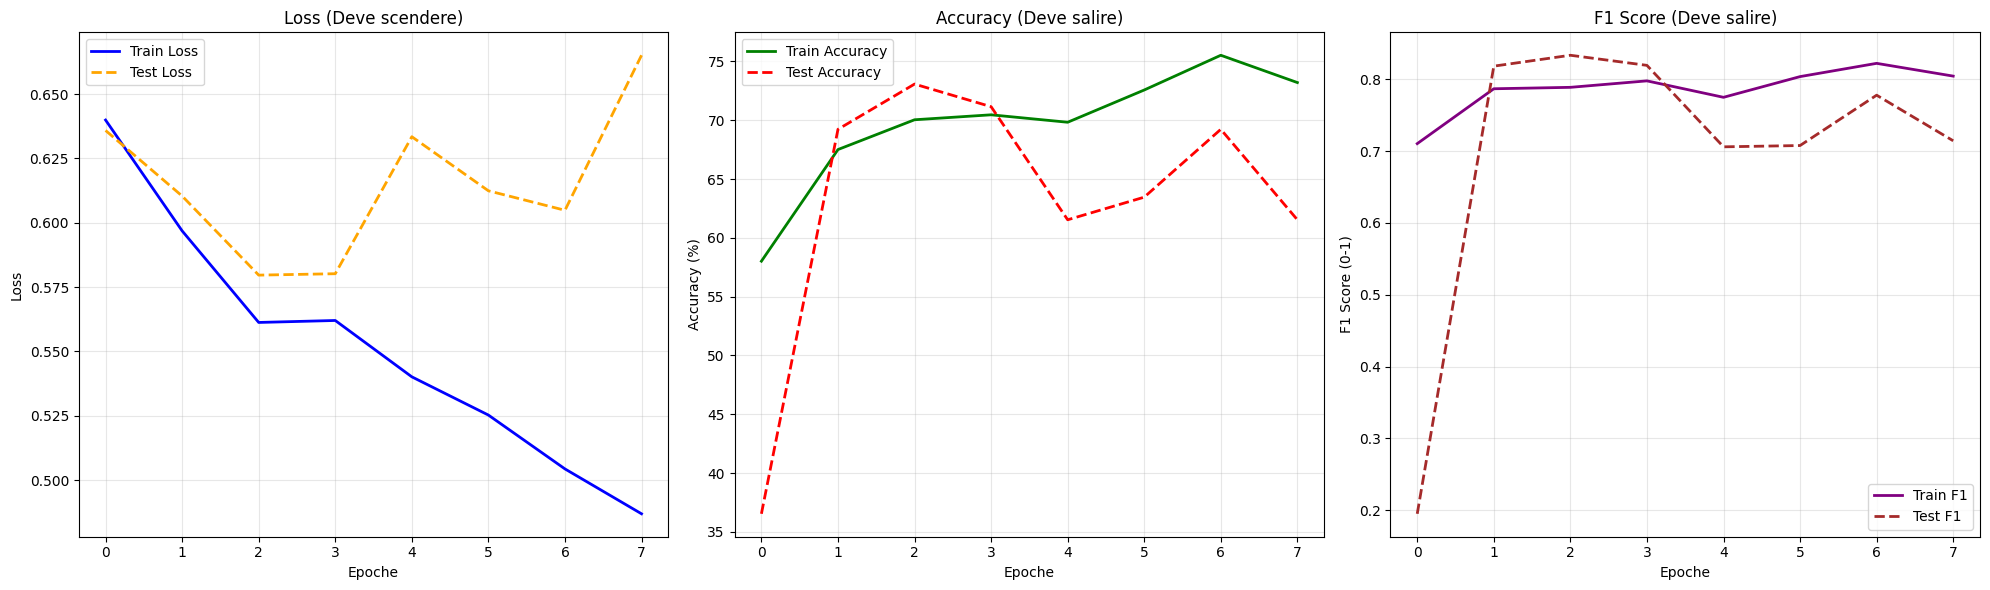

In [ ]:
import matplotlib.pyplot as plt

# Creiamo una figura con 3 grafici affiancati (1 riga, 3 colonne)
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# --- Grafico 1: LOSS (Errore) ---
# Questo ci dice se il modello sta imparando (deve scendere)
axs[0].plot(train_loss_single_fold, label='Train Loss', color='blue', linewidth=2)
axs[0].plot(test_loss_single_fold, label='Test Loss', color='orange', linestyle='--', linewidth=2)
axs[0].set_title('Loss (Deve scendere)')
axs[0].set_xlabel('Epoche')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# --- Grafico 2: ACCURACY ---
# Ci dice la percentuale totale di risposte corrette (deve salire)
axs[1].plot(accuracy_list_single_fold_train, label='Train Accuracy', color='green', linewidth=2)
axs[1].plot(accuracy_list_single_fold, label='Test Accuracy', color='red', linestyle='--', linewidth=2)
axs[1].set_title('Accuracy (Deve salire)')
axs[1].set_xlabel('Epoche')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# --- Grafico 3: F1 SCORE ---
# Critico per dati sbilanciati o medici: media armonica tra precisione e recupero
axs[2].plot(f1_list_single_fold_train, label='Train F1', color='purple', linewidth=2)
axs[2].plot(f1_list_single_fold, label='Test F1', color='brown', linestyle='--', linewidth=2)
axs[2].set_title('F1 Score (Deve salire)')
axs[2].set_xlabel('Epoche')
axs[2].set_ylabel('F1 Score (0-1)')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

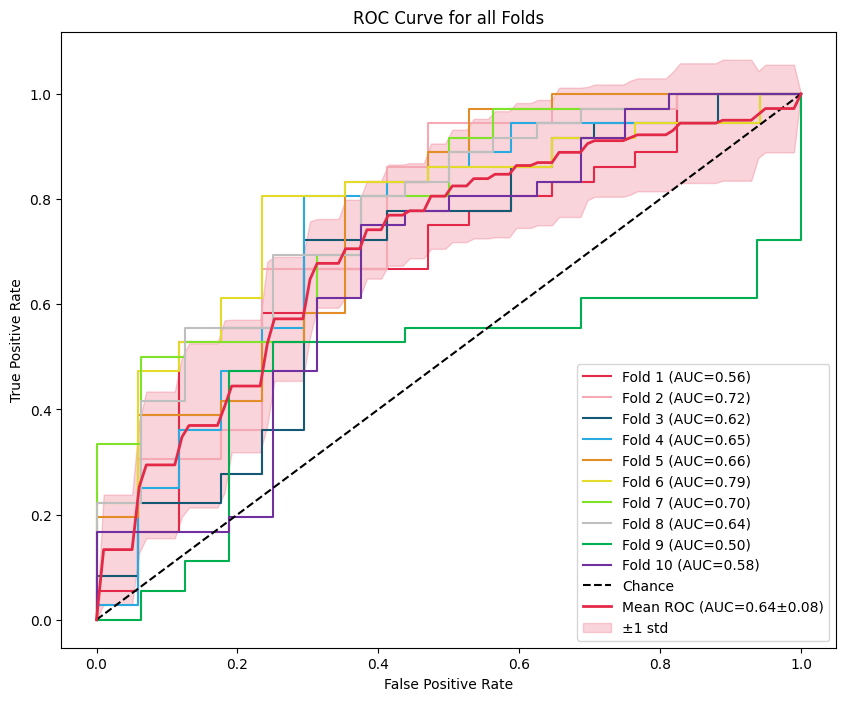

In [ ]:
plt.figure(figsize=(10, 8))

# Custom color palette
colors = [
    "#E32947",  # red
    "#F4A9B5",  # pink
    "#155874",  # dark blue
    "#29ABE2",  # light blue
    "#E38D29",  # orange
    "#E3DA29",  # yellow
    "#7FE329",  # green (flashy)
    "#BFBFBF",  # grey
    "#00B050",  # green (basic)
    "#7030A0",  # purple
    "#996633",  # brown
]
# Repeat colors if more folds than colors
while len(colors) < len(fpr_list_all_folds):
    colors += colors

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for i in range(len(fpr_list_all_folds)):
    interp_tpr = np.interp(mean_fpr, fpr_list_all_folds[i], tpr_list_all_folds[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    auc_val = auc_score_list_all_folds[i] if i < len(auc_score_list_all_folds) else None
    aucs.append(auc_val)
    plt.plot(
        fpr_list_all_folds[i],
        tpr_list_all_folds[i],
        color=colors[i],
        label=f'Fold {i+1} (AUC={auc_val:.2f})'
    )

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')

# Mean and std curves
tprs = np.array(tprs)
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="#E32947",
    label=f'Mean ROC (AUC={mean_auc:.2f}±{std_auc:.2f})',
    linewidth=2
)
plt.fill_between(
    mean_fpr,
    mean_tpr - std_tpr,
    mean_tpr + std_tpr,
    color="#E32947",
    alpha=0.2,
    label='±1 std'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all Folds')
plt.legend(loc='lower right')
plt.show()

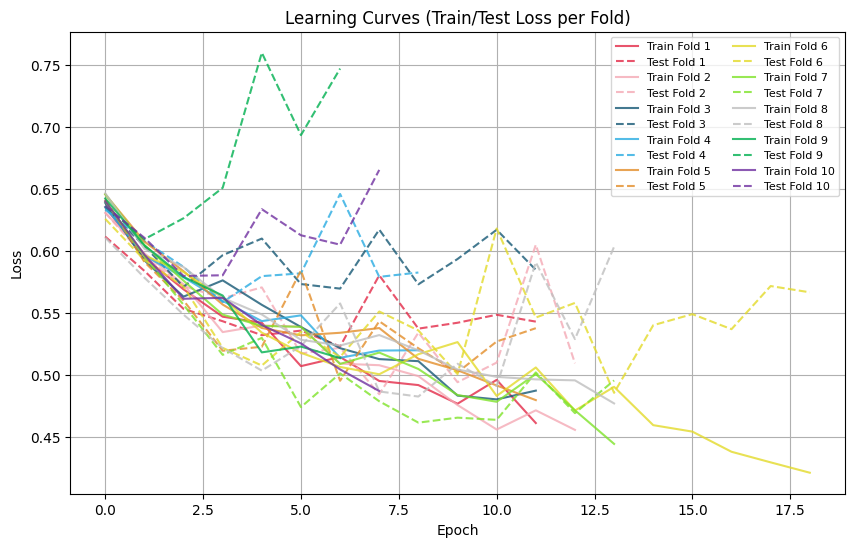

In [ ]:
# Plot learning curves (train and test loss per epoch for each fold)
plt.figure(figsize=(10, 6))

for i in range(len(train_loss_all_folds)):
    plt.plot(train_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, label=f'Train Fold {i+1}')
    plt.plot(test_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, linestyle='--', label=f'Test Fold {i+1}')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves (Train/Test Loss per Fold)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()

=== REPORT PERFORMANCE MEDIE (10-Fold CV) ===
      Accuracy  F1 Score  Sensitivity (Recall)  Specificity     AUC
mean    0.7529    0.8414                0.9500       0.3261  0.6381
std     0.0453    0.0189                0.0520       0.2486  0.0994
min     0.6923    0.8182                0.8611       0.0000  0.5000
max     0.8302    0.8732                1.0000       0.7647  0.8129


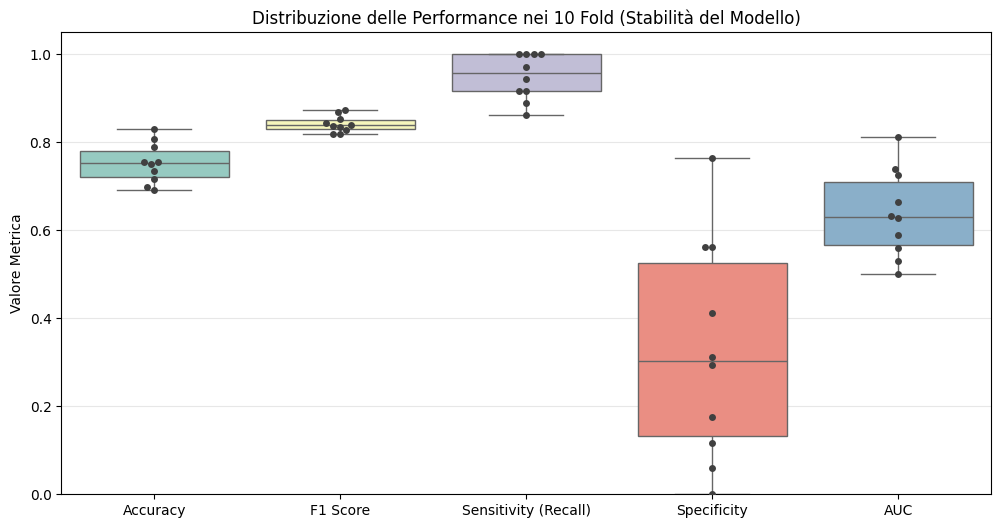

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Creazione di un DataFrame con tutti i risultati
results_data = {
    'Accuracy': np.array(accuracy_list_all_folds) / 100,  # <--- DIVISO PER 100
    'F1 Score': f1_list_all_folds,
    'Sensitivity (Recall)': sensitivity_list_all_folds,
    'Specificity': specificity_list_all_folds,
    'AUC': auc_score_list_all_folds
}

df_results = pd.DataFrame(results_data)

# 2. Calcolo delle Statistiche (Media e Deviazione Standard)
# La deviazione standard (std) ti dice quanto il modello è "instabile" tra un fold e l'altro
summary = df_results.describe().loc[['mean', 'std', 'min', 'max']]

print("=== REPORT PERFORMANCE MEDIE (10-Fold CV) ===")
print(summary.round(4))

# 3. Visualizzazione Grafica (Boxplot)
# Questo grafico è fondamentale: la linea verde è la mediana, la scatola è dove cade il 50% dei casi.
# Se la scatola è molto "alta", il modello è instabile. Se è schiacciata, è molto robusto.
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, palette="Set3")
sns.swarmplot(data=df_results, color=".25") # Aggiunge i punti reali per vedere la dispersione

plt.title('Distribuzione delle Performance nei 10 Fold (Stabilità del Modello)')
plt.ylabel('Valore Metrica')
plt.grid(True, axis='y', alpha=0.3)
plt.ylim(0, 1.05) # Fissa l'asse Y tra 0 e 1 (o poco più per l'accuracy se è in %)
# Se l'accuracy è in scala 0-100, commenta la riga sopra o adattala a (0, 105)

plt.show();

## Modello 3

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc, confusion_matrix
import numpy as np
import copy
from tqdm import tqdm

# --- 1. PREPROCESSING & DATASET ---
def stack_leads_ecg(signal, labels, segment_length=2500):
    n_patients = signal.shape[0]
    stacked_signals = np.zeros((n_patients, segment_length, 12))
    stacked_signals[:, :, :6] = signal[:, :segment_length, :6]   # Limb
    stacked_signals[:, :, 6:] = signal[:, segment_length:segment_length*2, 6:] # Chest
    return stacked_signals, labels

class AugmentedECGDataset(Dataset):
    def __init__(self, signals, labels, augment=False):
        self.signals = torch.tensor(signals, dtype=torch.float32).permute(0, 2, 1)
        self.labels = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)
        self.augment = augment
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        sig = self.signals[idx]
        lab = self.labels[idx]
        if self.augment:
            if torch.rand(1) < 0.5: sig = sig + (torch.randn_like(sig) * 0.05)
            if torch.rand(1) < 0.5: sig = sig * (1 + (torch.rand(1) * 0.2 - 0.1))
        return sig, lab

# --- 2. MODELLO TWO-STREAM ---
class TwoStreamCNN(nn.Module):
    def __init__(self):
        super(TwoStreamCNN, self).__init__()
        # Ramo 1 (Limb)
        self.branch1 = nn.Sequential(
            nn.Conv1d(6, 32, 5, padding=2), nn.BatchNorm1d(32), nn.GELU(), nn.MaxPool1d(2), nn.Dropout(0.2),
            nn.Conv1d(32, 64, 5, padding=2), nn.BatchNorm1d(64), nn.GELU(), nn.MaxPool1d(2), nn.Dropout(0.2)
        )
        # Ramo 2 (Chest)
        self.branch2 = nn.Sequential(
            nn.Conv1d(6, 32, 5, padding=2), nn.BatchNorm1d(32), nn.GELU(), nn.MaxPool1d(2), nn.Dropout(0.2),
            nn.Conv1d(32, 64, 5, padding=2), nn.BatchNorm1d(64), nn.GELU(), nn.MaxPool1d(2), nn.Dropout(0.2)
        )
        # Fusione
        self.fusion_conv = nn.Sequential(
            nn.Conv1d(128, 256, 3, padding=1), nn.BatchNorm1d(256), nn.GELU(), nn.MaxPool1d(2), nn.Dropout(0.3)
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(256, 128), nn.GELU(), nn.Dropout(0.5), nn.Linear(128, 1)
        )
    def forward(self, x):
        out1 = self.branch1(x[:, :6, :])
        out2 = self.branch2(x[:, 6:, :])
        combined = torch.cat((out1, out2), dim=1)
        features = self.fusion_conv(combined)
        features = self.global_pool(features).squeeze(-1)
        return self.classifier(features) # Logits per BCEWithLogitsLoss

# --- 3. IMPOSTAZIONI E VARIABILI ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
num_epocs = 100
patience = 15

# Tue liste originali
train_loss_all_folds, test_loss_all_folds = [], []
accuracy_list_all_folds, accuracy_list_all_folds_train = [], []
f1_list_all_folds, f1_list_all_folds_train = [], []
sensitivity_list_all_folds, sensitivity_list_all_folds_train = [], []
specificity_list_all_folds, specificity_list_all_folds_train = [], []
auc_score_list_all_folds, auc_score_list_all_folds_train = [], []

# --- 4. TRAINING LOOP ---
for fold, (train_idx, test_idx) in enumerate(strat_kf.split(tabular_data, tabular_data['sport_ability'])):
    print(f"Fold {fold+1}/5...")

    # Data Prep
    X_train, X_test = tabular_data.iloc[train_idx], tabular_data.iloc[test_idx]
    ecg_tr, y_tr = stack_leads_ecg(signals[train_idx], X_train['sport_ability'])
    ecg_te, y_te = stack_leads_ecg(signals[test_idx], X_test['sport_ability'])

    # Class Weights
    n_pos = y_tr.sum(); n_neg = len(y_tr) - n_pos
    pos_weight = torch.tensor([n_neg / n_pos]).to(device)

    # Loaders
    train_loader = DataLoader(AugmentedECGDataset(ecg_tr, y_tr, augment=True), batch_size=32, shuffle=True)
    test_loader = DataLoader(AugmentedECGDataset(ecg_te, y_te, augment=False), batch_size=32, shuffle=False)

    # Model
    model = TwoStreamCNN().to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Liste Singolo Fold
    train_loss_single, test_loss_single = [], []
    acc_train_single, acc_test_single = [], []
    f1_train_single, f1_test_single = [], []

    # Early Stopping
    best_loss = float('inf')
    patience_counter = 0
    best_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epocs):
        # TRAIN
        model.train()
        run_loss = 0; preds_tr = []; true_tr = []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
            preds_tr.extend((torch.sigmoid(out) > 0.5).cpu().numpy())
            true_tr.extend(y.cpu().numpy())

        # VAL
        model.eval()
        val_loss = 0; preds_te = []; true_te = []
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                val_loss += criterion(out, y).item()
                preds_te.extend((torch.sigmoid(out) > 0.5).cpu().numpy())
                true_te.extend(y.cpu().numpy())

        # Metriche Epoca
        ep_tr_loss = run_loss/len(train_loader)
        ep_te_loss = val_loss/len(test_loader)

        train_loss_single.append(ep_tr_loss); test_loss_single.append(ep_te_loss)
        acc_train_single.append(accuracy_score(true_tr, preds_tr)); acc_test_single.append(accuracy_score(true_te, preds_te))
        f1_train_single.append(f1_score(true_tr, preds_tr, average='macro')); f1_test_single.append(f1_score(true_te, preds_te, average='macro'))

        # Check Early Stopping
        if ep_te_loss < best_loss:
            best_loss = ep_te_loss
            best_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    # Salvataggio Liste Fold
    train_loss_all_folds.append(train_loss_single); test_loss_all_folds.append(test_loss_single)
    accuracy_list_all_folds_train.append(acc_train_single); accuracy_list_all_folds.append(acc_test_single)
    f1_list_all_folds_train.append(f1_train_single); f1_list_all_folds.append(f1_test_single)

    # Metriche Finali (Best Model)
    model.load_state_dict(best_wts)
    model.eval()
    final_preds, final_true = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            final_preds.extend((torch.sigmoid(model(x)) > 0.5).cpu().numpy())
            final_true.extend(y.numpy())

    # Calcolo Specificity/Sensitivity
    tn, fp, fn, tp = confusion_matrix(final_true, final_preds).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0

    sensitivity_list_all_folds.append(sens)
    specificity_list_all_folds.append(spec)
    print(f" -> F1: {f1_score(final_true, final_preds, average='macro'):.4f}, Spec: {spec:.4f}")

Fold 1/5...
 -> F1: 0.6053, Spec: 0.7353
Fold 2/5...
 -> F1: 0.6206, Spec: 0.6061
Fold 3/5...
 -> F1: 0.6245, Spec: 0.3333
Fold 4/5...
 -> F1: 0.7041, Spec: 0.6667
Fold 5/5...
 -> F1: 0.6115, Spec: 0.5455
